# Bibliotecas e preparação dos arquivos

In [474]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import os
from warnings import filterwarnings

from sklearn.model_selection import train_test_split
import xgboost as xgb

filterwarnings('ignore')
os.chdir(r"/Users/bentofh/Documents/GitHub/Walmart Sales Forecast/Arquivos CSV")
plt.rcParams['figure.figsize'] = (25, 8)

In [475]:
train = pd.read_csv('train.csv')
stores = pd.read_csv('stores.csv')
features = pd.read_csv('features.csv')
test = pd.read_csv('test.csv')

In [476]:
print('TRAIN - Range de datas:', train['Date'].min(), '|', train['Date'].max())
print('TEST  - Range de datas:', test['Date'].min(), '|', test['Date'].max())

TRAIN - Range de datas: 2010-02-05 | 2012-10-26
TEST  - Range de datas: 2012-11-02 | 2013-07-26


In [477]:
# Editando o df de treino

# Eliminando, pois essa coluna já existe em treino e teste
features = features.drop(columns='IsHoliday')

# Juntando as colunas de features dos arquivos Stores e Features
train_merge = pd.merge(train, stores, on='Store', how='left')
train_merge = pd.merge(train_merge, features, on=['Store', 'Date'], how='left')

# Editando o df
train_merge = train_merge.set_index('Date')
train_merge.index = pd.to_datetime(train_merge.index)

# Transformando coluna string em int
transf = {}

for i, valor in enumerate(train_merge['Type'].unique()):
    transf[valor] = i

train_merge['Type'] = train_merge['Type'].map(transf)

In [478]:
train_merge.head()

,Store,Dept,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
Date,,,,,,,,,,,,,,,
2010-02-05,1,1,24924.50,False,0,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
2010-02-12,1,1,46039.49,True,0,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2010-02-19,1,1,41595.55,False,0,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
2010-02-26,1,1,19403.54,False,0,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
2010-03-05,1,1,21827.90,False,0,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106


In [479]:
# Categorias de lojas
print(transf)
print('A - Range do tamanho das lojas:', train_merge.loc[train_merge['Type'] == 0, 'Size'].min(), '|', train_merge.loc[train_merge['Type'] == 0, 'Size'].max())
print('B - Range do tamanho das lojas:', train_merge.loc[train_merge['Type'] == 1, 'Size'].min(), '|', train_merge.loc[train_merge['Type'] == 1, 'Size'].max())
print('C - Range do tamanho das lojas:', train_merge.loc[train_merge['Type'] == 2, 'Size'].min(), '|', train_merge.loc[train_merge['Type'] == 2, 'Size'].max())

{'A': 0, 'B': 1, 'C': 2}
A - Range do tamanho das lojas: 39690 | 219622
B - Range do tamanho das lojas: 34875 | 140167
C - Range do tamanho das lojas: 39690 | 42988


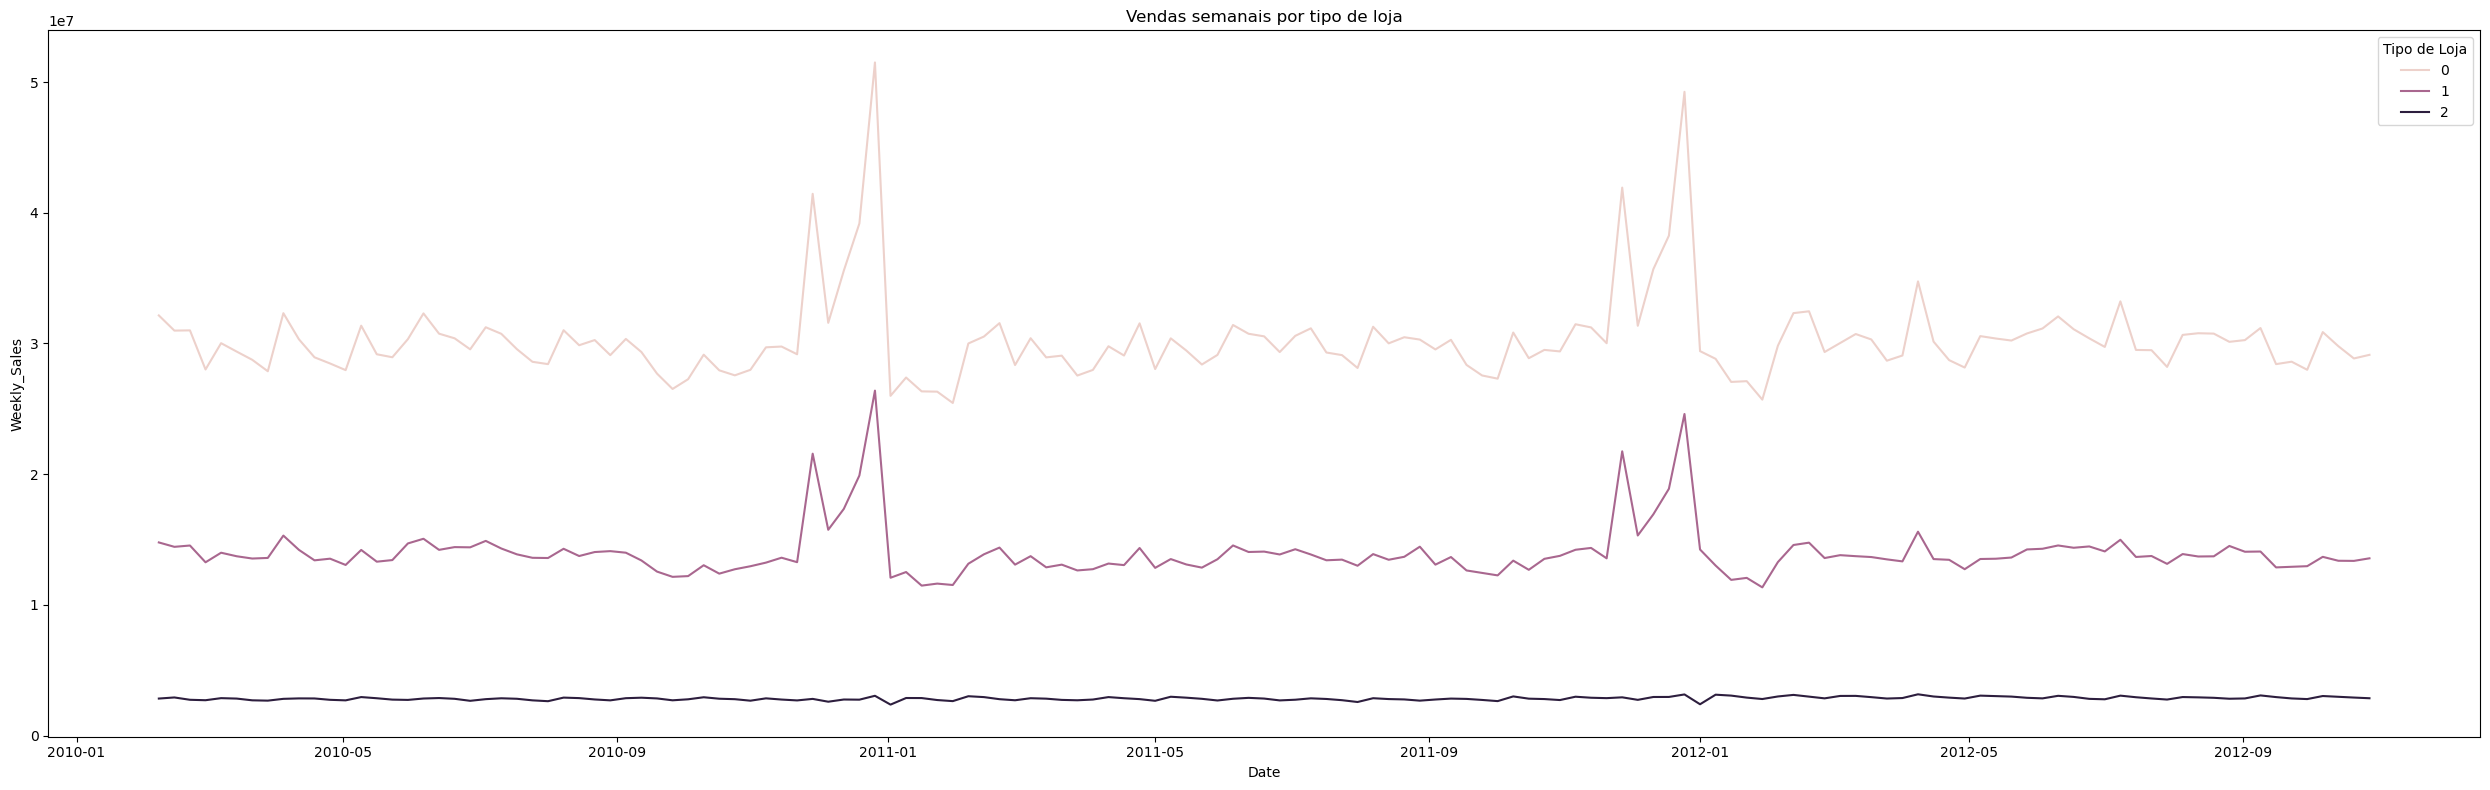

In [480]:
# Plotando o somatório das vendas por tipo de loja 
# {'A': 0, 'B': 1, 'C': 2}

sales_by_type_weekly = train_merge.groupby('Type').resample('W')['Weekly_Sales'].sum().reset_index()

sns.lineplot(data=sales_by_type_weekly, x='Date', y='Weekly_Sales', hue='Type')
plt.title('Vendas semanais por tipo de loja')
plt.legend(title='Tipo de Loja')
plt.tight_layout()
plt.show()

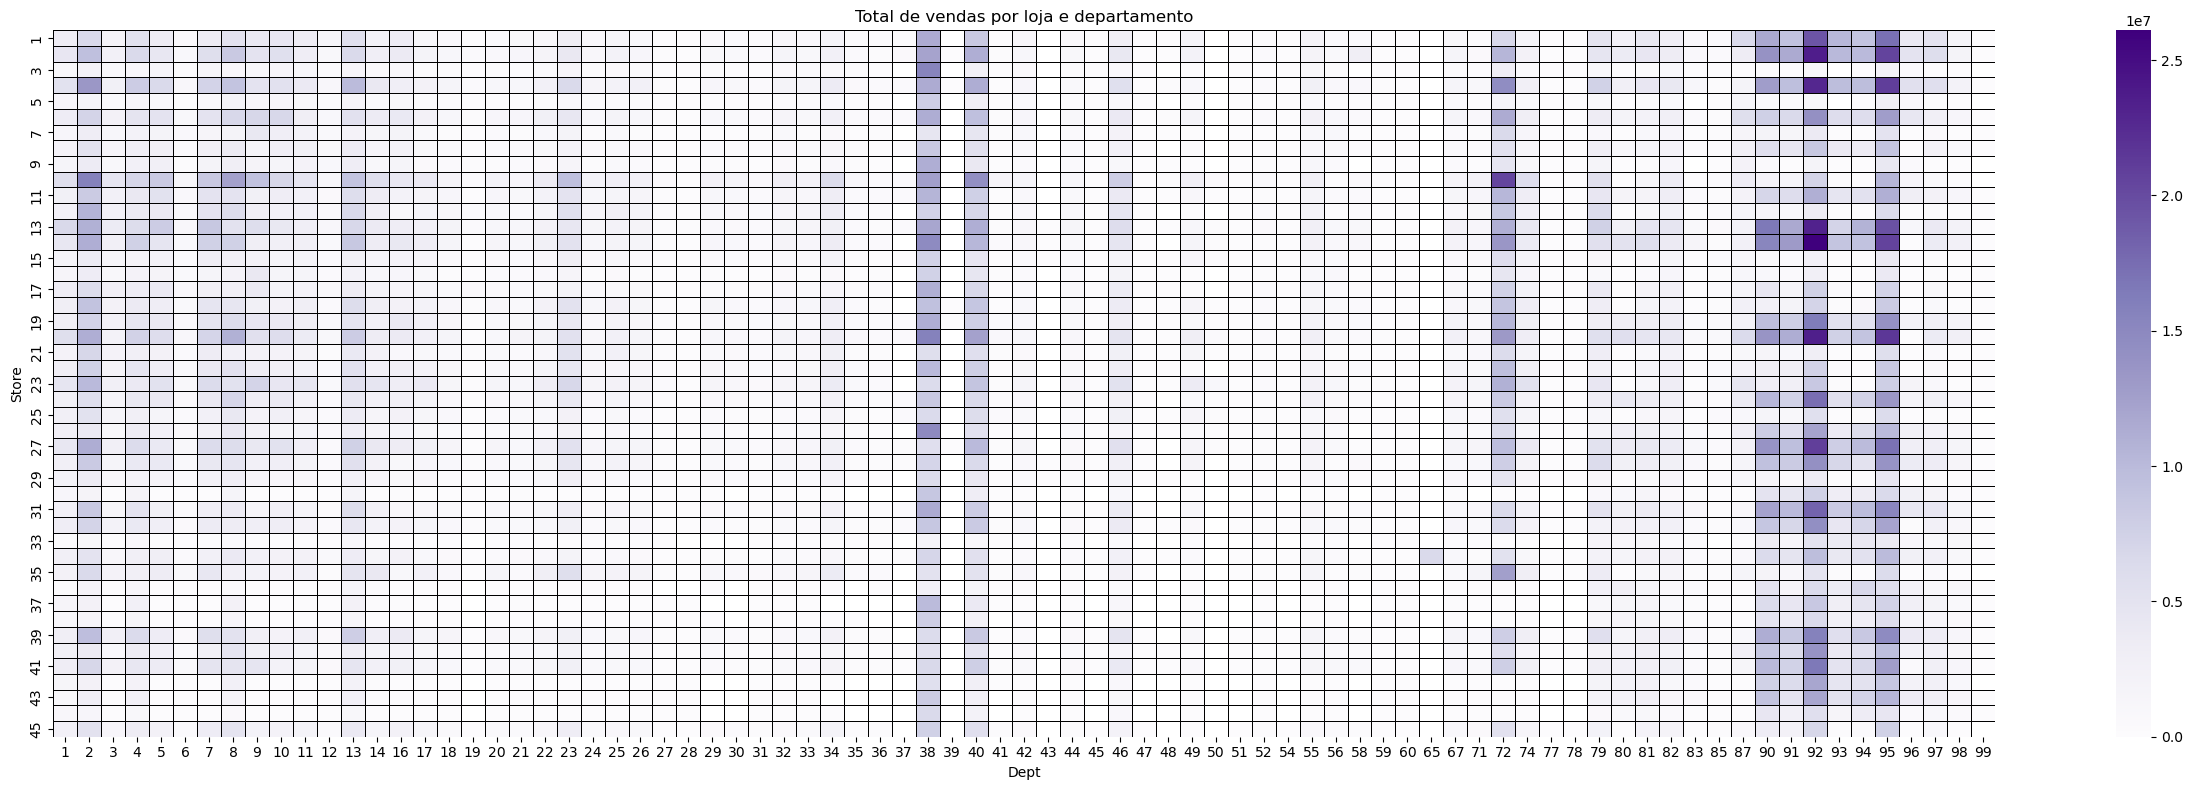

In [481]:
# Heatmap da somatória de vendas por departamentos

sales_by_store_dept = train_merge.groupby(['Store', 'Dept'])['Weekly_Sales'].sum().reset_index()
sales_pivot = sales_by_store_dept.pivot(index='Store', columns='Dept', values='Weekly_Sales')

sns.heatmap(sales_pivot, cmap='Purples', linewidths=0.5, linecolor='black')
plt.title('Total de vendas por loja e departamento')
plt.tight_layout()
plt.show()

# Forecast

### Separando apenas dept = 1 para validação

In [482]:
# Decidi separar os modelos por tipo de departamento
# Escolhi o dept = 1 para começarmos a explorar as possibilidades

dept1 = train_merge[train_merge['Dept'] == 1]
dept1 = dept1.drop(columns='Dept')
dept1.head()

,Store,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
Date,,,,,,,,,,,,,,
2010-02-05,1,24924.50,False,0,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
2010-02-12,1,46039.49,True,0,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2010-02-19,1,41595.55,False,0,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
2010-02-26,1,19403.54,False,0,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
2010-03-05,1,21827.90,False,0,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106


### Criando lags

In [483]:
dept1['lag6'] = dept1.groupby('Store')['Weekly_Sales'].shift(6) # Começando do lag 6 pq quero prever 6 semanas no futuro
dept1['lag7'] = dept1.groupby('Store')['Weekly_Sales'].shift(7)
dept1['lag8'] = dept1.groupby('Store')['Weekly_Sales'].shift(8)
dept1['lag9'] = dept1.groupby('Store')['Weekly_Sales'].shift(9)
dept1['lag10'] = dept1.groupby('Store')['Weekly_Sales'].shift(10)
dept1['lag11'] = dept1.groupby('Store')['Weekly_Sales'].shift(11)
dept1['lag12'] = dept1.groupby('Store')['Weekly_Sales'].shift(12)

In [484]:
# Validando o compartamento dos lags que criei acima
dept1[['Store','Weekly_Sales','lag6','lag7','lag8','lag9','lag10','lag11','lag12']][dept1['Store'].isin([30])].sort_index(level=0, ascending=False).tail(20)

,Store,Weekly_Sales,lag6,lag7,lag8,lag9,lag10,lag11,lag12
Date,,,,,,,,,
2010-06-18,30,8741.00,10468.47,9503.51,9563.17,9401.71,13070.12,13723.71,11678.69
2010-06-11,30,9325.99,9503.51,9563.17,9401.71,13070.12,13723.71,11678.69,9771.21
2010-06-04,30,9864.11,9563.17,9401.71,13070.12,13723.71,11678.69,9771.21,10560.49
2010-05-28,30,10312.66,9401.71,13070.12,13723.71,11678.69,9771.21,10560.49,9719.90
2010-05-21,30,9535.18,13070.12,13723.71,11678.69,9771.21,10560.49,9719.90,10099.28
2010-05-14,30,10217.95,13723.71,11678.69,9771.21,10560.49,9719.90,10099.28,12321.18
2010-05-07,30,10468.47,11678.69,9771.21,10560.49,9719.90,10099.28,12321.18,14346.05
2010-04-30,30,9503.51,9771.21,10560.49,9719.90,10099.28,12321.18,14346.05,10158.77
2010-04-23,30,9563.17,10560.49,9719.90,10099.28,12321.18,14346.05,10158.77,NaN


In [485]:
# Drop NA para executar Feature Importance 
dept1_dropna = dept1.dropna()

### Feature Importance

In [486]:
# Separando as features do target
X = dept1_dropna.drop(columns='Weekly_Sales') 
y = dept1_dropna['Weekly_Sales']

# Lasso
from sklearn.linear_model import Lasso

lasso_model = Lasso(alpha=0.001)
lasso_model.fit(X, y)

featureImportance_Lasso = np.abs(lasso_model.coef_)

# RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(X, y)

featureImportance_RandomForestRegressor = np.abs(model.feature_importances_)

# GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor()
model.fit(X, y)

featureImportance_GradientBoostingRegressor = np.abs(model.feature_importances_)

# ExtraTreesRegressor
from sklearn.ensemble import ExtraTreesRegressor

model = ExtraTreesRegressor()
model.fit(X, y)

featureImportance_ExtraTreesRegressor = np.abs(model.feature_importances_)

In [487]:
# Salvar os resultados em um DataFrame
results_df = pd.DataFrame({
    'Feature': X.columns,
    'Lasso': featureImportance_Lasso,
    'RandomForestRegressor': featureImportance_RandomForestRegressor,
    'GradientBoostingRegressor': featureImportance_GradientBoostingRegressor,
    'ExtraTreesRegressor': featureImportance_ExtraTreesRegressor
})

results_df.set_index('Feature', inplace=True)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Normalizando os resultados em escala de 0 a 1 
results_df['Lasso'] = scaler.fit_transform(results_df[['Lasso']]).round(5)
results_df['RandomForestRegressor'] = scaler.fit_transform(results_df[['RandomForestRegressor']]).round(5)
results_df['GradientBoostingRegressor'] = scaler.fit_transform(results_df[['GradientBoostingRegressor']]).round(5)
results_df['ExtraTreesRegressor'] = scaler.fit_transform(results_df[['ExtraTreesRegressor']]).round(5)

results_df['Média dos resultados'] = results_df.mean(axis=1)
results_df['Média dos resultados'] = scaler.fit_transform(results_df[['Média dos resultados']])
results_df = results_df.sort_values(by='Média dos resultados', ascending=False)

results_df.head(20)

,Lasso,RandomForestRegressor,GradientBoostingRegressor,ExtraTreesRegressor,Média dos resultados
Feature,,,,,
lag8,0.00006,1.00000,1.00000,1.00000,1.000000
lag7,0.00006,0.34162,0.38939,0.90771,0.540149
IsHoliday,1.00000,0.00808,0.04038,0.04881,0.357222
MarkDown3,0.00000,0.24796,0.23049,0.25058,0.232828
Type,0.66727,0.00000,0.00000,0.00190,0.212606
MarkDown2,0.00001,0.14919,0.22890,0.17817,0.174468
Fuel_Price,0.24954,0.07398,0.08727,0.08690,0.154679
lag9,0.00001,0.10054,0.06117,0.22302,0.116524
Temperature,0.02730,0.05833,0.12475,0.16526,0.113449


In [488]:
colunas = ['Weekly_Sales', 'Store', 'lag8', 'lag7', 'IsHoliday','Type','Fuel_Price','Temperature','lag6','lag9']

In [489]:
# Retornando todas as linhas com NA, para excluir os NAs agora somente das colunas que me interessam
# Removi as colunas de MarkDown pq elas tem muitos NAs. Verificar depois se dá pra resolver isso.
dept1 = dept1[colunas]
dept1 = dept1.dropna()

In [490]:
# Usando somente as features de acordo com a média acima
X = dept1[colunas].drop(columns='Weekly_Sales')
y = dept1['Weekly_Sales']

### Separando treino e teste

In [491]:
X_train = X[X.index < '2012-09-21']
y_train = y[y.index < '2012-09-21']
X_test = X[X.index >= '2012-09-21']
y_test = y[y.index >= '2012-09-21']

In [492]:
# Validando o corte das datas cima
if X_train.index.min() == y_train.index.min() and X_train.index.max() == y_train.index.max():
    print("Treino: ", X_train.index.min(), "|", X_train.index.max())
else:
    print("Verificar datas do treino")

if X_test.index.min() == y_test.index.min() and X_test.index.max() == y_test.index.max():
    print("Teste : ", X_test.index.min(), "|", X_test.index.max())
else:
    print("Verificar datas do teste")

Treino:  2010-04-09 00:00:00 | 2012-09-14 00:00:00
Teste :  2012-09-21 00:00:00 | 2012-10-26 00:00:00


### Treino XGBRegressor

In [493]:
model = xgb.XGBRegressor(verbosity=1)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### Avaliação dos valores reais X previstos

In [494]:
predictions = model.predict(X_test)

In [495]:
df_resultados = pd.DataFrame({'Data': X_test.index, 'Valor_Real': y_test, 'Valor_Predito': predictions})
df_resultados.reset_index(inplace=True)
df_resultados = df_resultados.drop(columns=['Date'])
df_resultados['Data'] = pd.to_datetime(df_resultados['Data'])

df_resultados = df_resultados.groupby('Data')[['Valor_Real', 'Valor_Predito']].sum().reset_index()
df_resultados['Valor_Predito'] = df_resultados['Valor_Predito'].round(decimals=2)

df_resultados.sort_values(by='Data', inplace=True)

df_resultados.head()

,Data,Valor_Real,Valor_Predito
0,2012-09-21,740105.84,745093.1250
1,2012-09-28,754344.66,731428.2500
2,2012-10-05,855362.83,764185.8125
3,2012-10-12,936707.78,819640.2500
4,2012-10-19,1037182.46,875364.7500


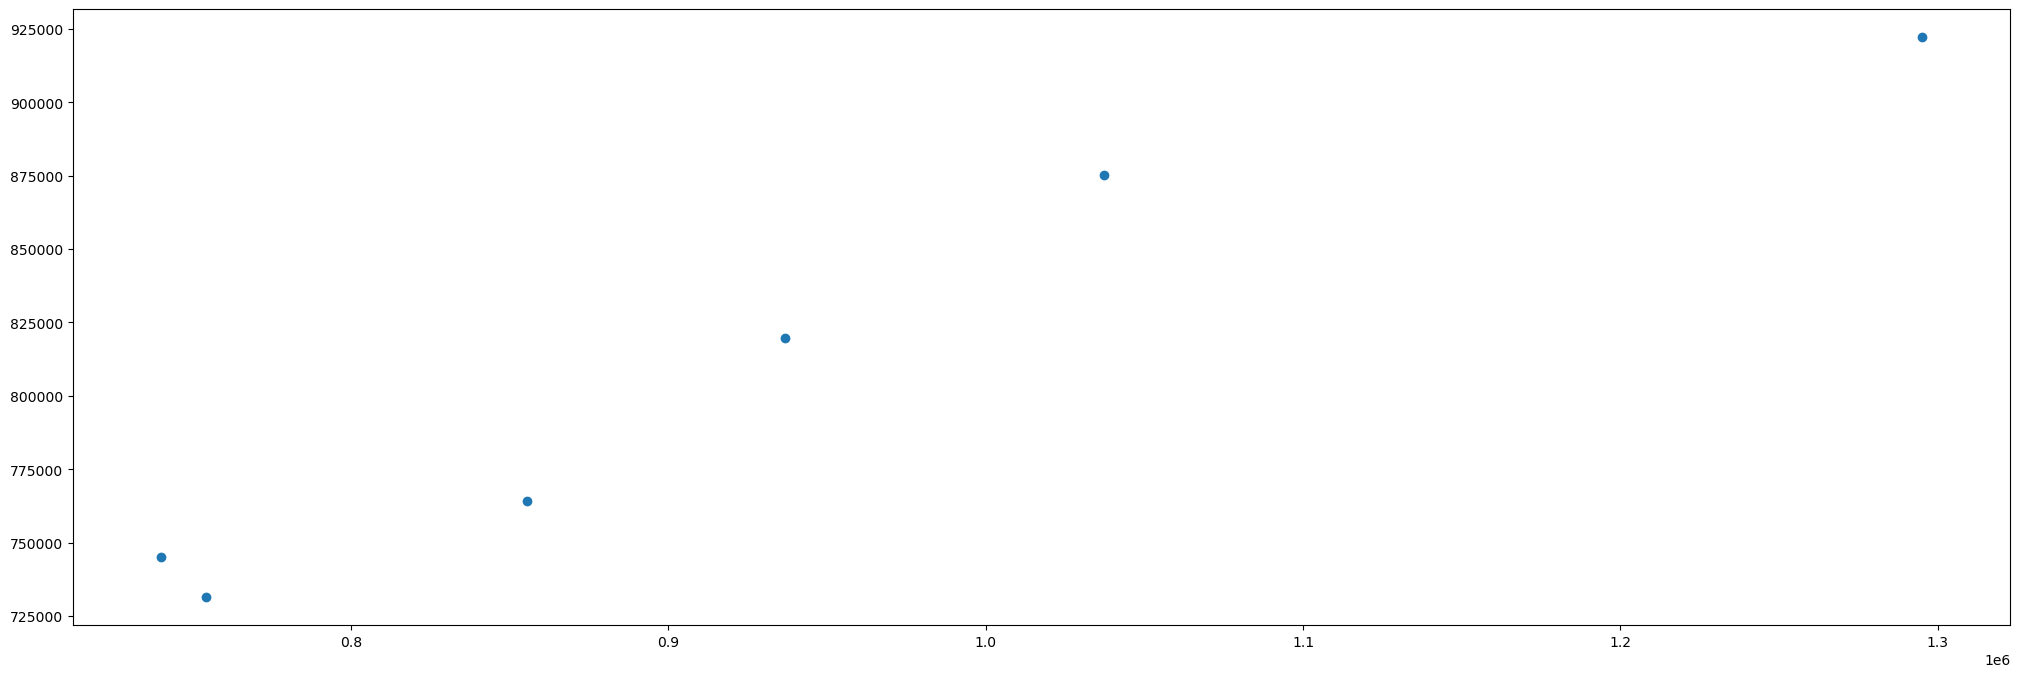

In [496]:
# Gráfico de dispersão com os valores reais e os preditos
# Analiser se o resultado parece uma distribuição que seria possível traçar uma linha 
plt.scatter(df_resultados['Valor_Real'], df_resultados['Valor_Predito'])
plt.show()

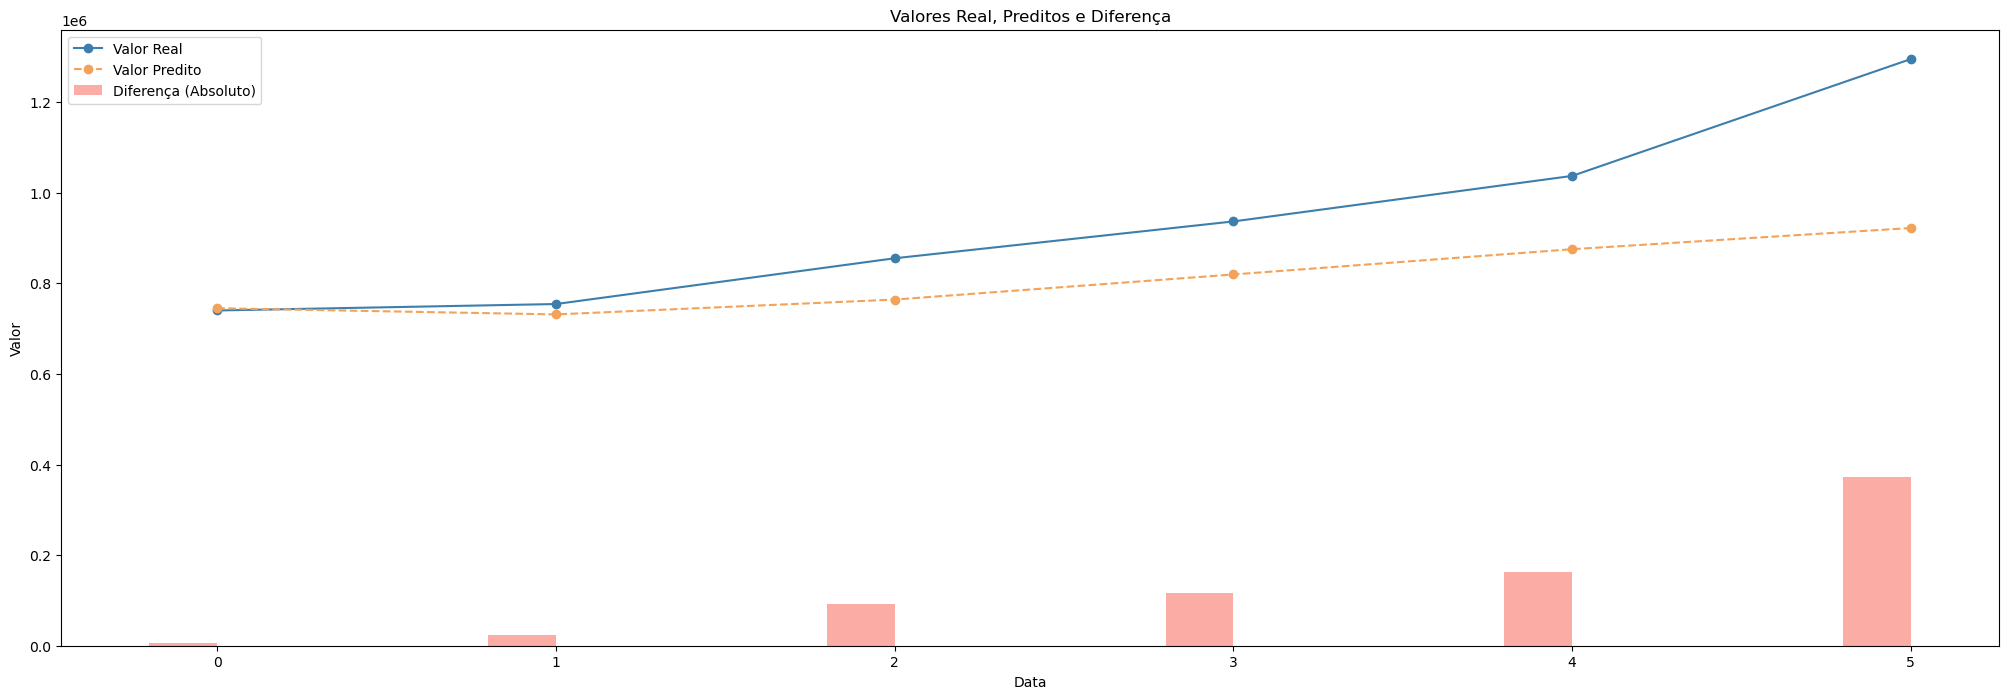

In [497]:
# Gráfico com os valores reais e preditos nas linhas + valores de erro nas barras

# Criando a coluna de diferença
df_resultados['Diferenca'] = df_resultados['Valor_Real'] - df_resultados['Valor_Predito']

# Plotar o gráfico de linha para os valores real e predito
plt.plot(df_resultados.index, df_resultados['Valor_Real'], color='#3e7eac', label='Valor Real', marker='o')
plt.plot(df_resultados.index, df_resultados['Valor_Predito'], color='#f4a258', label='Valor Predito', marker='o', linestyle='--')

bar_width = 0.2
plt.bar(df_resultados.index - bar_width/2, df_resultados['Diferenca'].abs(), color='#fbaca4', label='Diferença (Absoluto)', width=bar_width)

plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Valores Real, Preditos e Diferença')
plt.legend()
plt.show()

### Métricas de erro (ET, Bias, MAE, RMSE e MAPE)

In [498]:
predictions = model.predict(X_test)

# Erro
error = np.sum(predictions - y_test).round(2)

# Viés (Bias)
bias = np.mean(predictions - y_test).round(2)
bias_perc = (np.sum(predictions - y_test) / np.sum(y_test)).round(2) * 100

# Erro Absoluto Médio (MAE)
mae = np.mean(np.abs(predictions - y_test)).round(2)
mae_perc = np.sum(np.abs(predictions - y_test) / np.sum(y_test)).round(2) * 100

# Erro Quadrático Médio (RMSE)
rmse = np.sqrt(np.mean((predictions - y_test) ** 2)).round(2)
rmse_perc = (np.sqrt(np.mean((predictions - y_test) ** 2)) / np.mean(y_test)).round(2) * 100

# Erro Percentual Absoluto Médio (MAPE)
mape = (np.mean(np.abs((predictions - y_test) / y_test))).round(2) * 100

# Decidi já imprimir os resultados em escala de erro %
print("Erro Total:", error)
print("Viés:", bias, "| %", bias_perc)
print("Erro Absoluto Médio (MAE):", mae, "| %", mae_perc)
print("Erro Quadrático Médio (RMSE):", rmse, "| %", rmse_perc)
print("Erro Percentual Absoluto Médio (MAPE): %", mape)

Erro Total: -760979.63
Viés: -2818.44 | % -14.000000000000002
Erro Absoluto Médio (MAE): 4025.34 | % 19.0
Erro Quadrático Médio (RMSE): 6054.74 | % 28.999999999999996
Erro Percentual Absoluto Médio (MAPE): % 18.0


# Previsões com datas futuras

### Fazendo as transformações necessárias para deixar o test.csv no mesmo padrão do df utilizado no treino

In [499]:
# Consultado o df de treino para pegar a estrutura padrão
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [500]:
# Adicionar a coluna de Weekly_Sales no dataset de teste para ficar igual ao de treino
# O Range de previsão pré definido por mim foram 6 semanas do futuro, sendo de 02/11/2012 até 07/12/2012
data_inicio = '2012-11-02'
data_fim = '2012-12-07'
test = test[(test['Date'] >= data_inicio) & (test['Date'] <= data_fim)]
test['Weekly_Sales'] = np.nan
test.head()

,Store,Dept,Date,IsHoliday,Weekly_Sales
0,1,1,2012-11-02,False,NaN
1,1,1,2012-11-09,False,NaN
2,1,1,2012-11-16,False,NaN
3,1,1,2012-11-23,True,NaN
4,1,1,2012-11-30,False,NaN


In [501]:
# Juntando os dois dataframes para aplicar todas as alterações feitas lá em cima, para 
# deixá-lo no mesmo padrão do utilizado no treino do modelo e conseguirmos prever os valores que não temos
df_combined = pd.concat([test, train])
df_combined.head()

,Store,Dept,Date,IsHoliday,Weekly_Sales
0,1,1,2012-11-02,False,NaN
1,1,1,2012-11-09,False,NaN
2,1,1,2012-11-16,False,NaN
3,1,1,2012-11-23,True,NaN
4,1,1,2012-11-30,False,NaN


In [502]:
# Transformando o dataset de test (futuro) no mesmo padrão do utilizado no modelo

# Juntando as colunas de features dos arquivos Stores e Features
test_merge = pd.merge(df_combined, stores, on='Store', how='left')
test_merge = pd.merge(test_merge, features, on=['Store', 'Date'], how='left')

# Index
test_merge['Date'] = pd.to_datetime(test_merge['Date'])
test_merge = test_merge.sort_values(by=['Store', 'Date'])
test_merge = test_merge.set_index('Date')

# Transformando coluna string em int
transf = {}

for i, valor in enumerate(test_merge['Type'].unique()):
    transf[valor] = i

test_merge['Type'] = test_merge['Type'].map(transf)

In [503]:
dept1_forecast = test_merge[test_merge['Dept'] == 1]
dept1_forecast = dept1_forecast.drop(columns='Dept')
dept1_forecast.head()

,Store,IsHoliday,Weekly_Sales,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
Date,,,,,,,,,,,,,,
2010-02-05,1,False,24924.50,0,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
2010-02-12,1,True,46039.49,0,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2010-02-19,1,False,41595.55,0,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
2010-02-26,1,False,19403.54,0,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
2010-03-05,1,False,21827.90,0,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106


In [504]:
# Criando as lags
dept1_forecast['lag6'] = dept1_forecast.groupby('Store')['Weekly_Sales'].shift(6)
dept1_forecast['lag7'] = dept1_forecast.groupby('Store')['Weekly_Sales'].shift(7)
dept1_forecast['lag8'] = dept1_forecast.groupby('Store')['Weekly_Sales'].shift(8)
dept1_forecast['lag9'] = dept1_forecast.groupby('Store')['Weekly_Sales'].shift(9)
dept1_forecast['lag10'] = dept1_forecast.groupby('Store')['Weekly_Sales'].shift(10)
dept1_forecast['lag11'] = dept1_forecast.groupby('Store')['Weekly_Sales'].shift(11)
dept1_forecast['lag12'] = dept1_forecast.groupby('Store')['Weekly_Sales'].shift(12)

In [505]:
# Verificando se funcionou
dept1_forecast[['Store', 'Weekly_Sales', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12']][dept1_forecast['Store'] == 1].sort_values(by='Date', ascending=False).head(10)

,Store,Weekly_Sales,lag6,lag7,lag8,lag9,lag10,lag11,lag12
Date,,,,,,,,,
2012-12-07,1,NaN,27390.81,24185.27,22764.01,21904.47,18947.81,19251.50,19616.22
2012-11-30,1,NaN,24185.27,22764.01,21904.47,18947.81,19251.50,19616.22,18322.37
2012-11-23,1,NaN,22764.01,21904.47,18947.81,19251.50,19616.22,18322.37,16680.24
2012-11-16,1,NaN,21904.47,18947.81,19251.50,19616.22,18322.37,16680.24,16286.40
2012-11-09,1,NaN,18947.81,19251.50,19616.22,18322.37,16680.24,16286.40,17330.70
2012-11-02,1,NaN,19251.50,19616.22,18322.37,16680.24,16286.40,17330.70,16119.92
2012-10-26,1,27390.81,19616.22,18322.37,16680.24,16286.40,17330.70,16119.92,16628.31
2012-10-19,1,24185.27,18322.37,16680.24,16286.40,17330.70,16119.92,16628.31,15731.18
2012-10-12,1,22764.01,16680.24,16286.40,17330.70,16119.92,16628.31,15731.18,16348.06


In [506]:
# Separando somente as colunas necessários igualmente utilizadas para treinar o modelo

dept1_forecast = dept1_forecast[colunas].drop(columns='Weekly_Sales')
dept1_forecast.head()

,Store,lag8,lag7,IsHoliday,Type,Fuel_Price,Temperature,lag6,lag9
Date,,,,,,,,,
2010-02-05,1,NaN,NaN,False,0,2.572,42.31,NaN,NaN
2010-02-12,1,NaN,NaN,True,0,2.548,38.51,NaN,NaN
2010-02-19,1,NaN,NaN,False,0,2.514,39.93,NaN,NaN
2010-02-26,1,NaN,NaN,False,0,2.561,46.63,NaN,NaN
2010-03-05,1,NaN,NaN,False,0,2.625,46.50,NaN,NaN


### Aplicando modelo em datas futuras

In [507]:
# Separando somente as datas que eu quero prever, sendo >= 02/nov

X_forecast = dept1_forecast[dept1_forecast.index >= '2012-11-02']

In [508]:
# Aplicando o modelo

forecast = model.predict(X_forecast)

In [509]:
df_forecast = pd.DataFrame({'Date': X_forecast.index, 'Store': X_forecast['Store'], 'Forecast': forecast})
df_forecast.reset_index(drop=True, inplace=True)
df_forecast['Date'] = pd.to_datetime(df_forecast['Date'])

forecast_groupby_date = df_forecast.groupby('Date')['Forecast'].sum().reset_index()
forecast_groupby_date_store = df_forecast.groupby(['Store', 'Date'])['Forecast'].sum().reset_index()

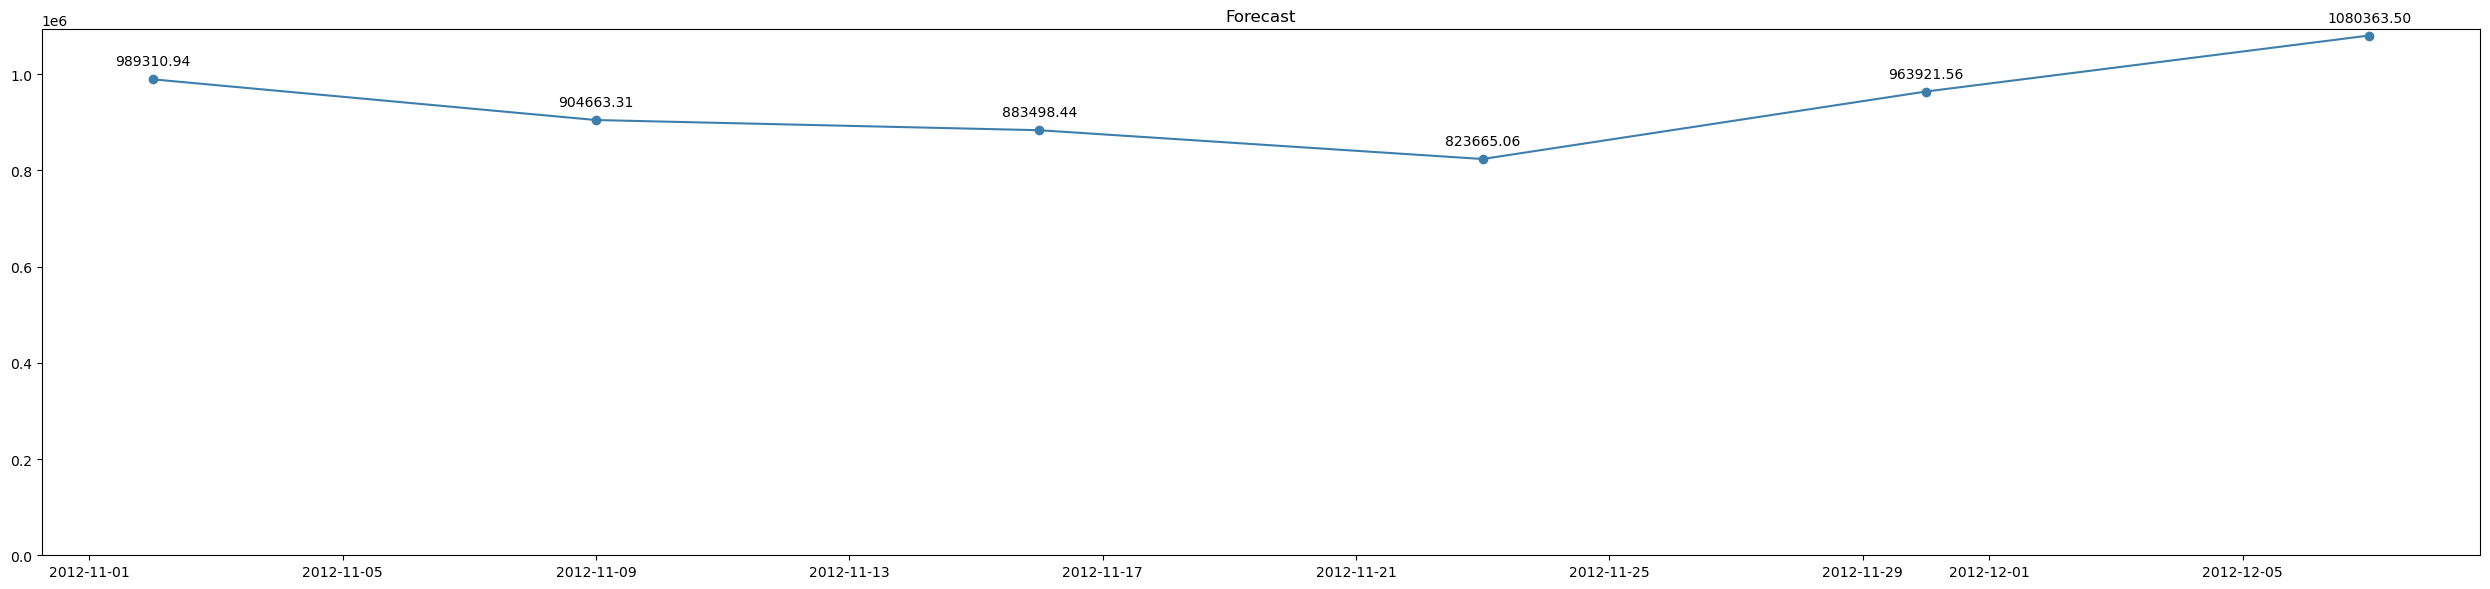

In [510]:
# Gráfico de tempo com o somatório do forecast de todas as lojas do dept = 1 pelas próximas 6 semanas

plt.figure(figsize=(25, 6))
plt.plot(forecast_groupby_date['Date'], forecast_groupby_date['Forecast'], marker='o', linestyle='-', color='#3e7eac')

for x, y in zip(forecast_groupby_date['Date'], forecast_groupby_date['Forecast']):
    plt.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')

plt.title('Forecast')
plt.ylim(bottom=0)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### Analisando Forecast por loja 

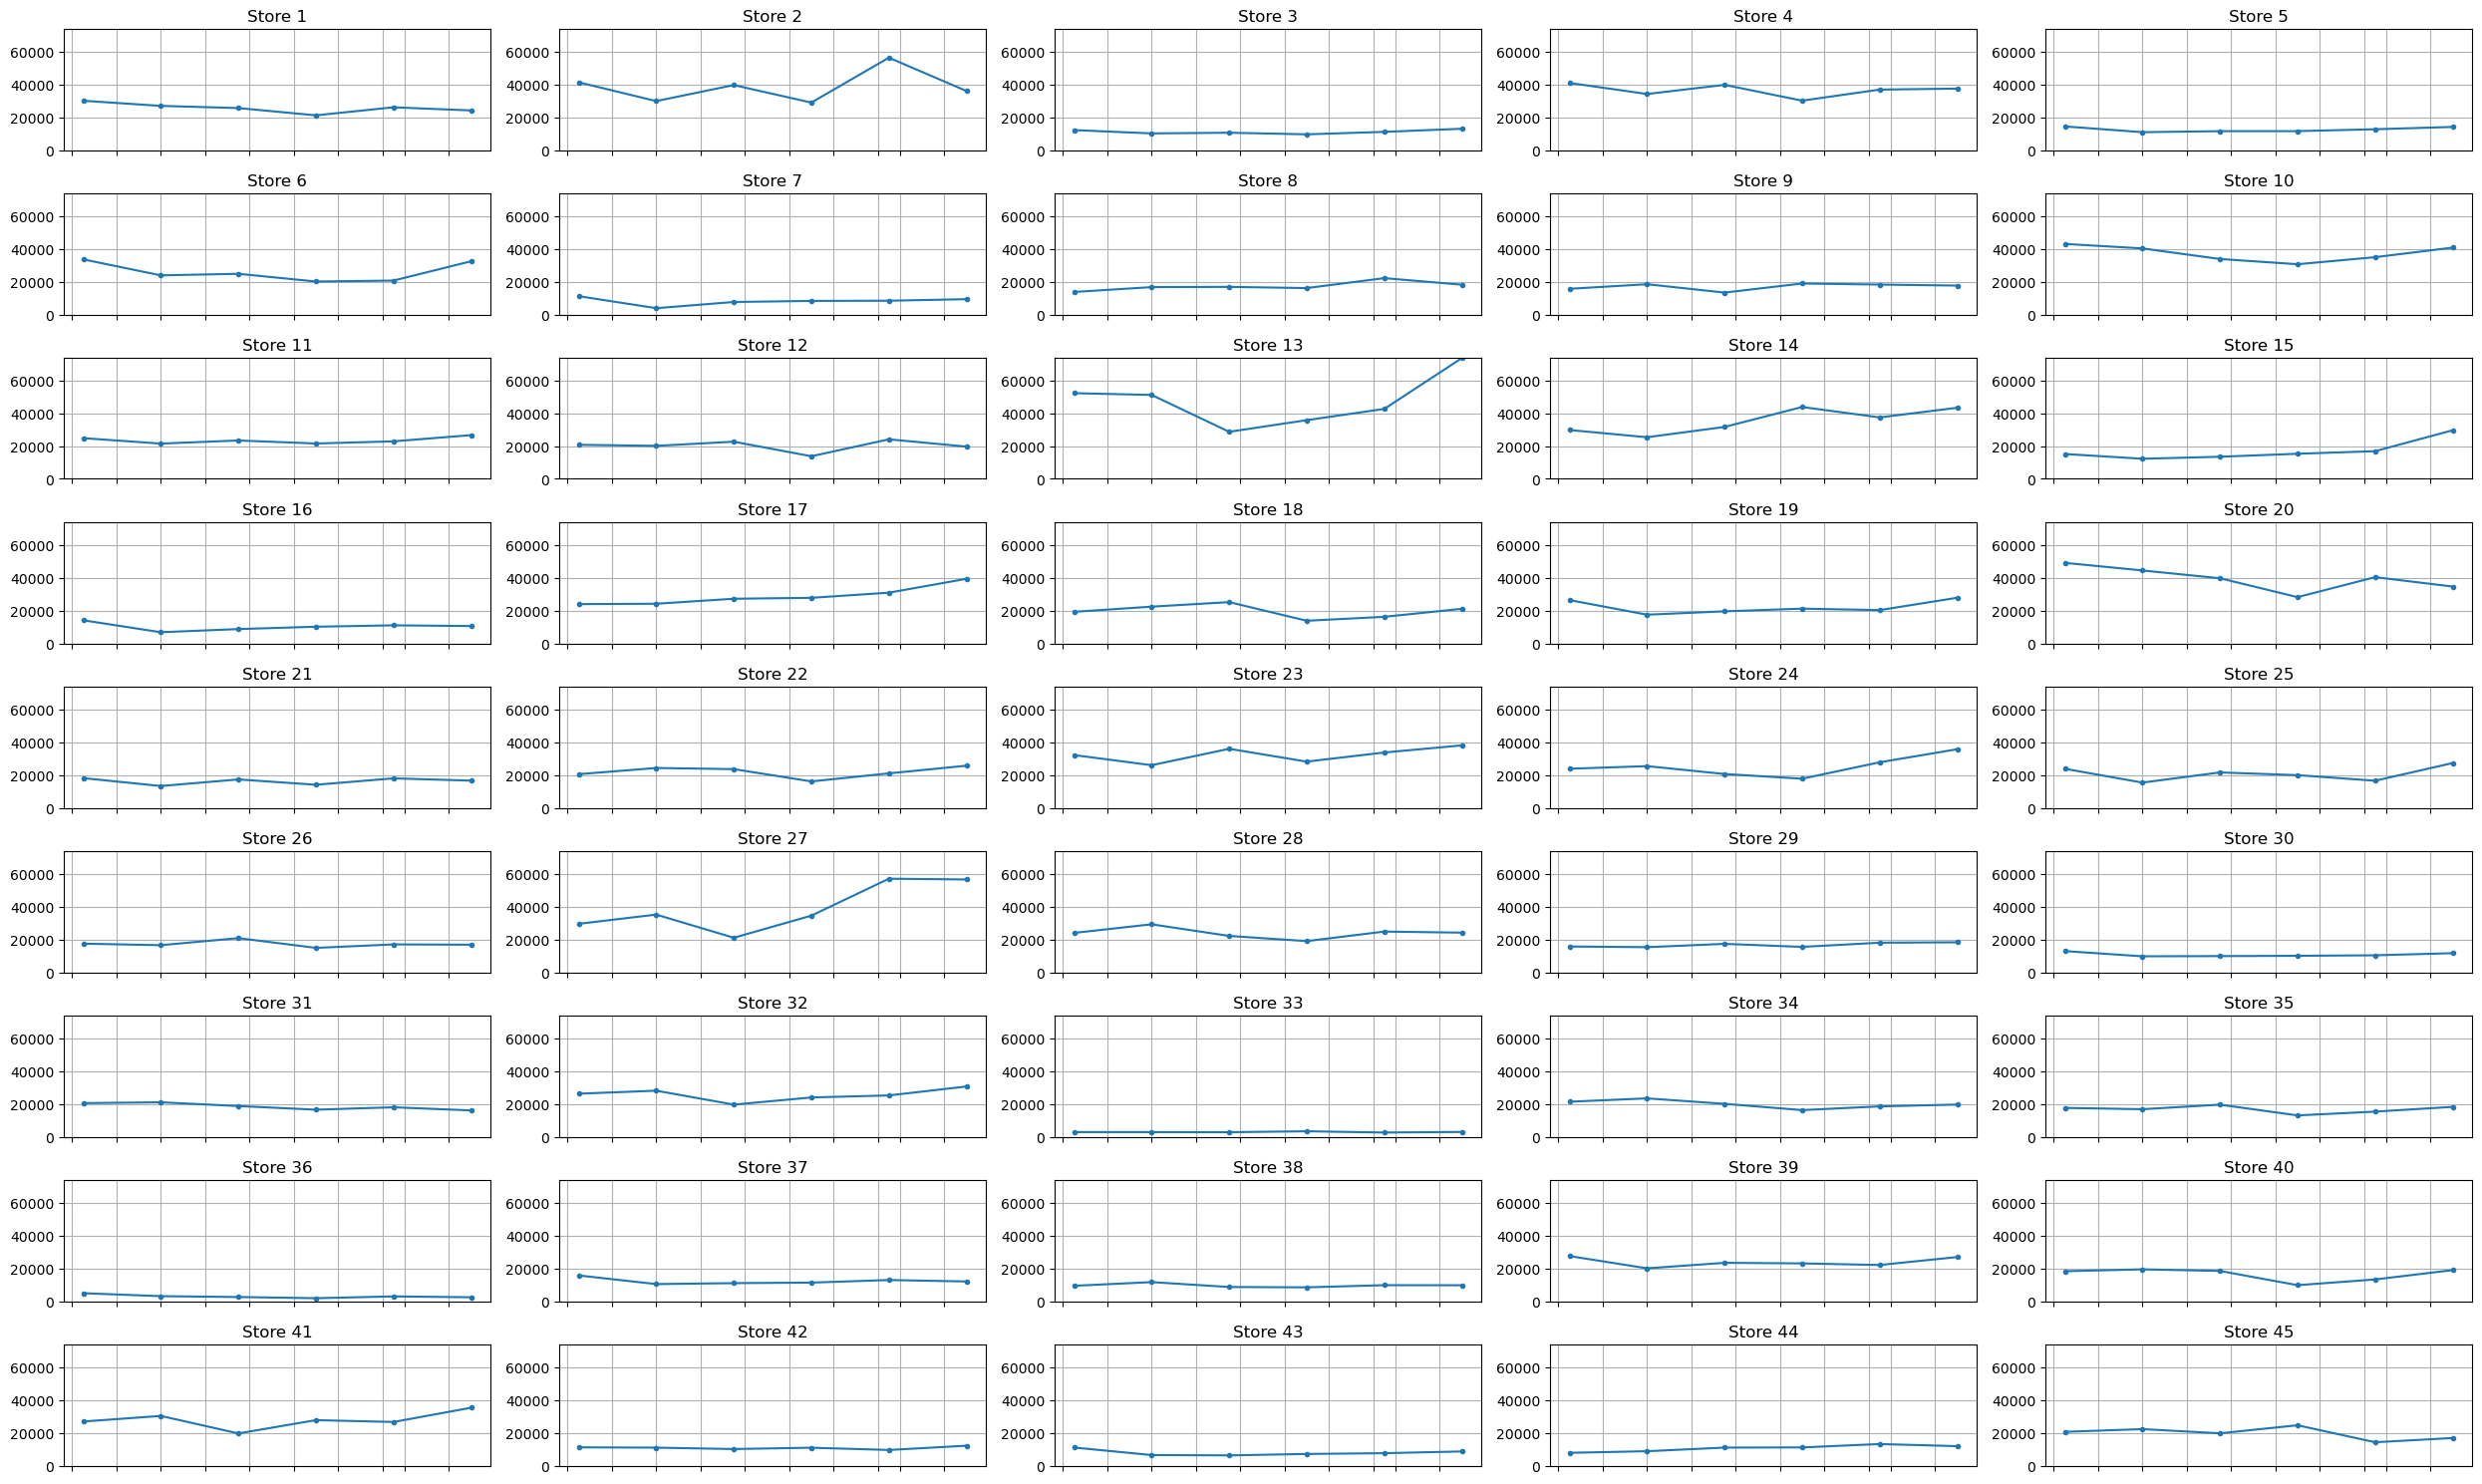

In [511]:
# Gráfico de tempo com o valor de forecast por semana para cada uma das 45 lojas apenas do dept = 1
fig, axs = plt.subplots(9, 5, figsize=(25, 15))
ylim_top = forecast_groupby_date_store['Forecast'].max()

for ax, (store, data) in zip(axs.flatten(), forecast_groupby_date_store.groupby('Store')):
    ax.plot(data['Date'], data['Forecast'], marker='.')
    ax.set_title(f'Store {store}')
    ax.grid(True)
    ax.set_xticklabels([])
    ax.set_ylim(bottom=0)
    ax.set_ylim(top=ylim_top)
    
plt.tight_layout()
plt.show()

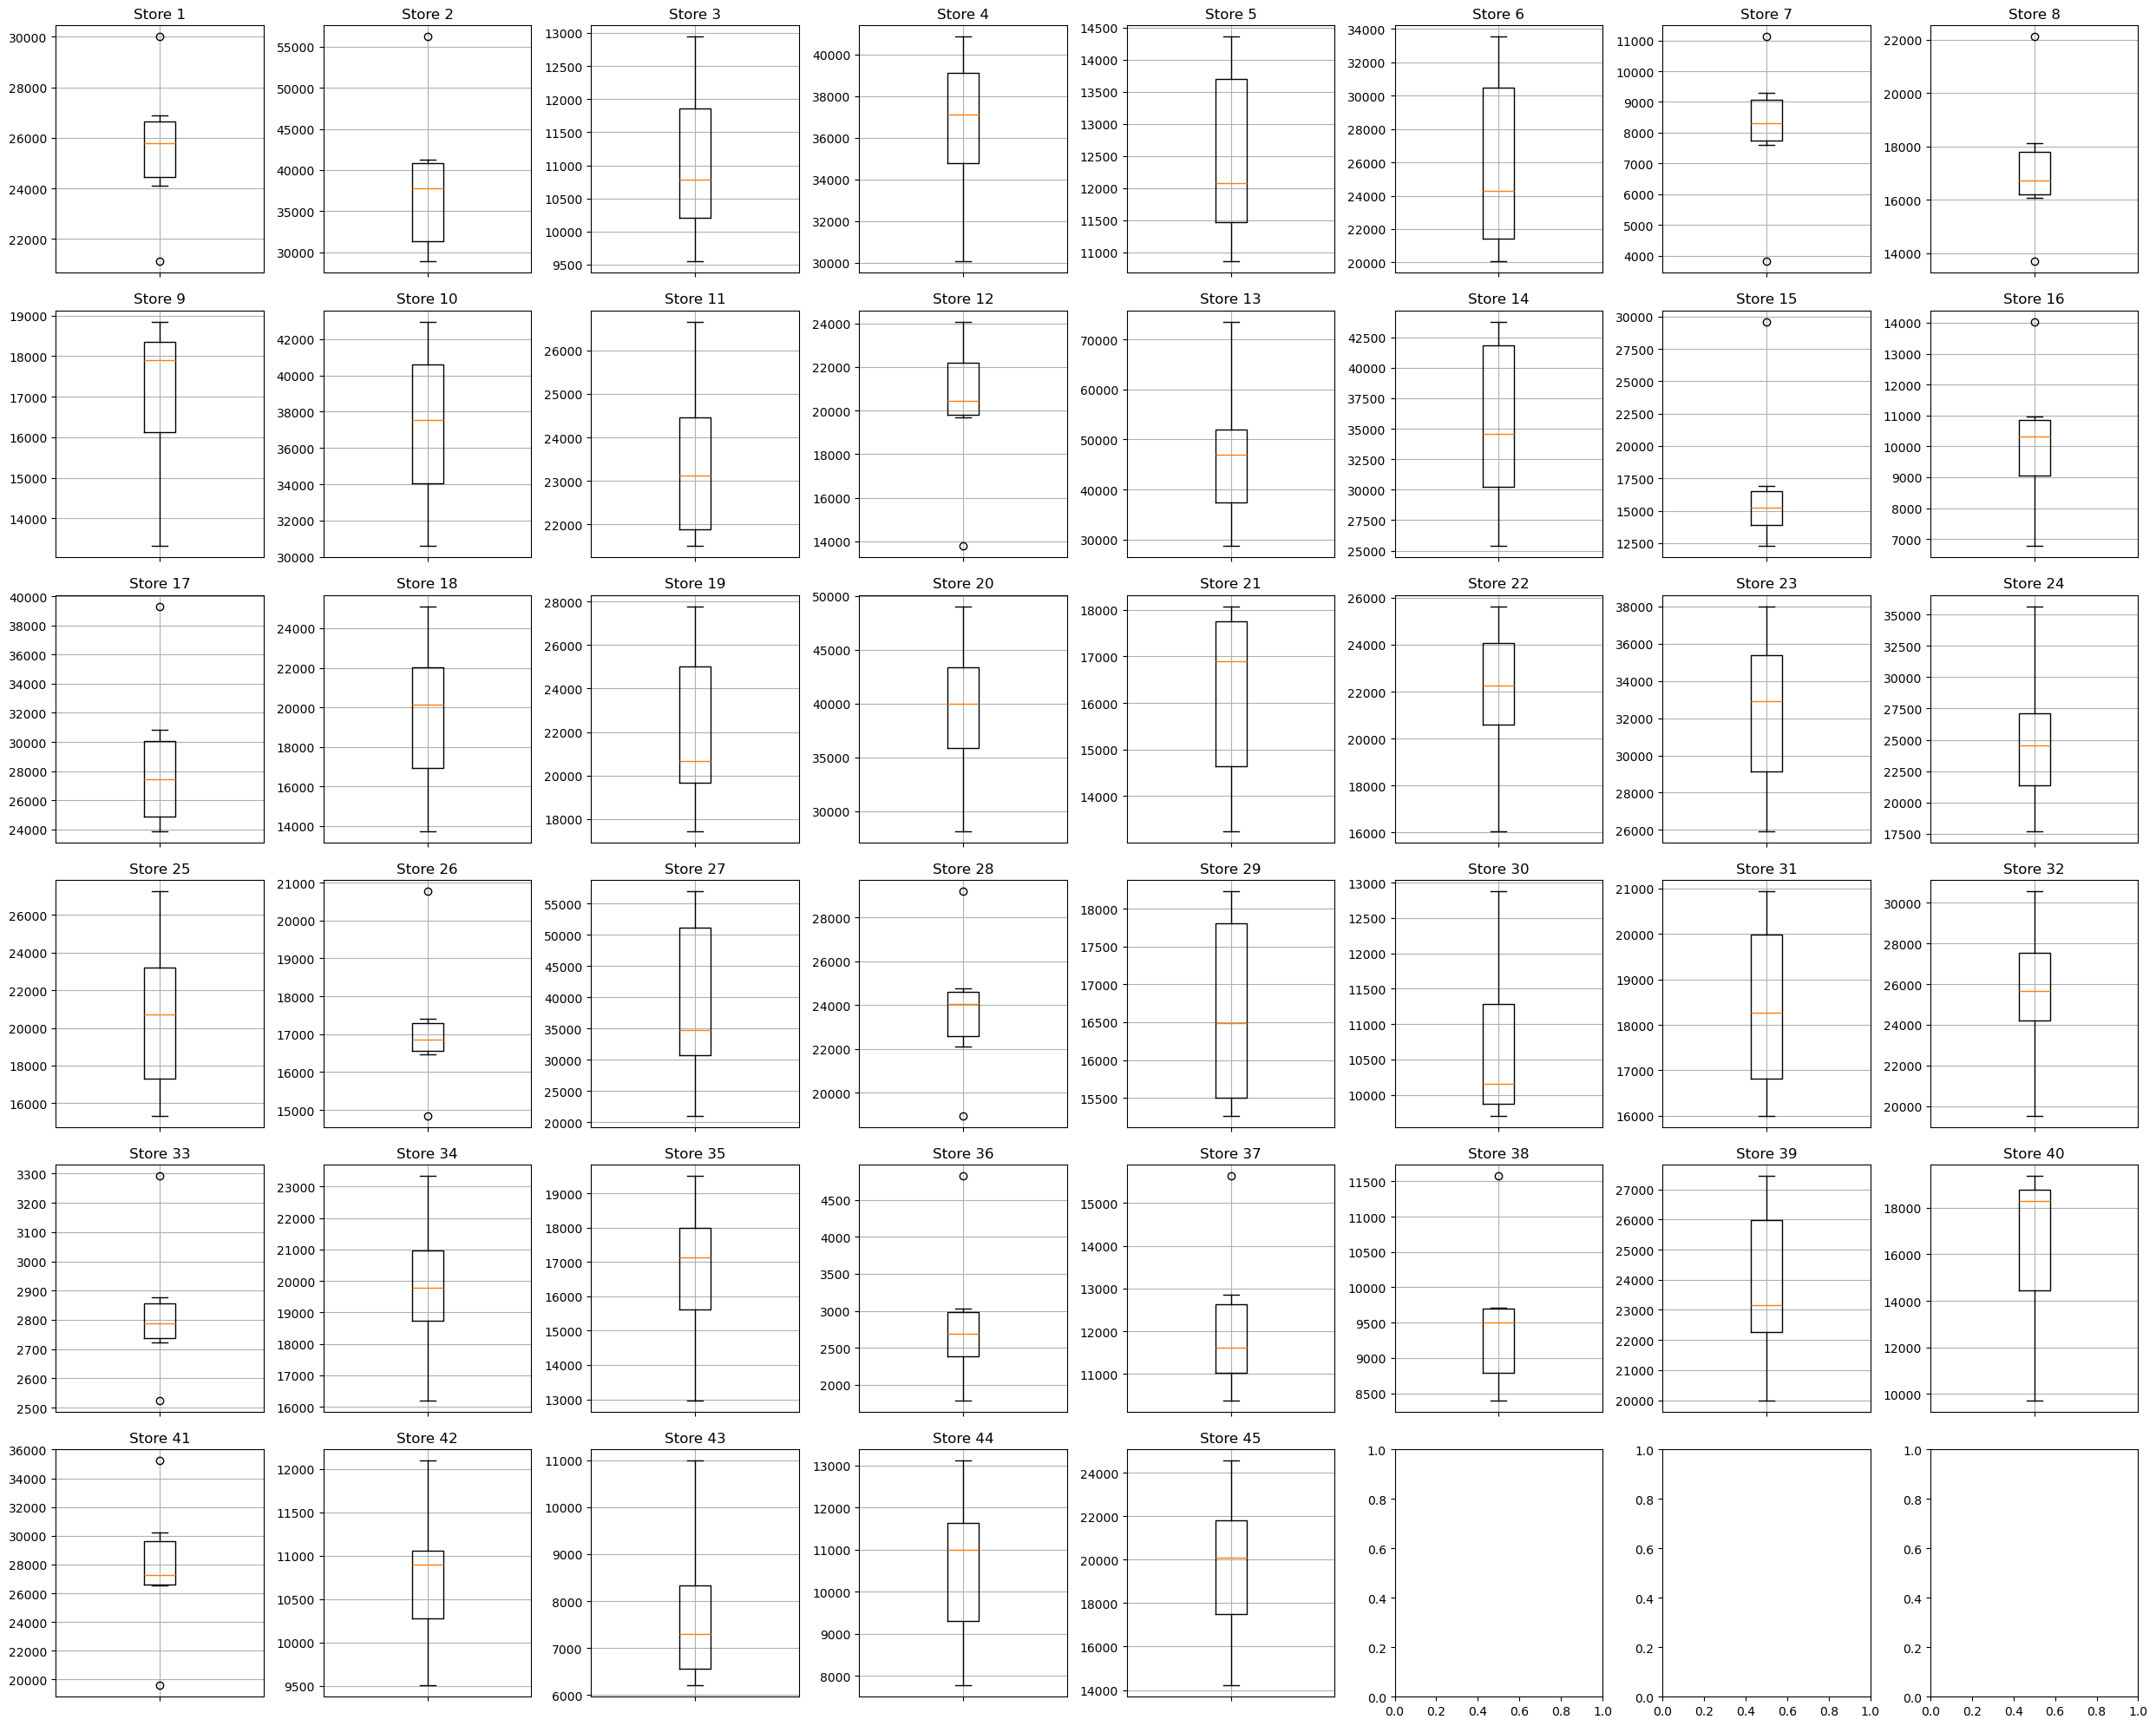

In [512]:
fig, axs = plt.subplots(6, 8, figsize=(25, 20))

# Gerar um boxplot para cada loja
for ax, (store, data) in zip(axs.flatten(), forecast_groupby_date_store.groupby('Store')):
    ax.boxplot(data['Forecast'], vert=True)
    ax.set_title(f'Store {store}')
    ax.grid(True)
    ax.set_xticklabels([])

# Ajustar o layout da figura
plt.tight_layout()
plt.show()

# Criar loop para treinar os modelos por departamento

### Editando o df

In [513]:
train_merge_loop = train_merge

In [514]:
# Atentar-se a agrupar agora também por Store + Dept

train_merge_loop['lag6'] = train_merge_loop.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(6) # Começando do lag 6 pq quero prever 6 semanas no futuro
train_merge_loop['lag7'] = train_merge_loop.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(7)
train_merge_loop['lag8'] = train_merge_loop.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(8)
train_merge_loop['lag9'] = train_merge_loop.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(9)
train_merge_loop['lag10'] = train_merge_loop.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(10)
train_merge_loop['lag11'] = train_merge_loop.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(11)
train_merge_loop['lag12'] = train_merge_loop.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(12)

In [515]:
# Validando o compartamento dos lags que criei acima

train_merge_loop[['Store', 'Dept', 'Weekly_Sales','lag6','lag7','lag8','lag9','lag10','lag11','lag12']][(train_merge['Store'] == 30) & (train_merge['Dept'] == 2)].sort_index(level=0, ascending=False).head(10)

,Store,Dept,Weekly_Sales,lag6,lag7,lag8,lag9,lag10,lag11,lag12
Date,,,,,,,,,,
2012-10-26,30,2,12919.04,12457.72,12518.38,12764.33,12490.72,13002.05,11415.10,12339.07
2012-10-19,30,2,12455.54,12518.38,12764.33,12490.72,13002.05,11415.10,12339.07,12486.97
2012-10-12,30,2,11582.65,12764.33,12490.72,13002.05,11415.10,12339.07,12486.97,12260.87
2012-10-05,30,2,12351.55,12490.72,13002.05,11415.10,12339.07,12486.97,12260.87,12141.54
2012-09-28,30,2,12702.83,13002.05,11415.10,12339.07,12486.97,12260.87,12141.54,12340.95
2012-09-21,30,2,12968.32,11415.10,12339.07,12486.97,12260.87,12141.54,12340.95,12459.02
2012-09-14,30,2,12457.72,12339.07,12486.97,12260.87,12141.54,12340.95,12459.02,12144.13
2012-09-07,30,2,12518.38,12486.97,12260.87,12141.54,12340.95,12459.02,12144.13,11909.72
2012-08-31,30,2,12764.33,12260.87,12141.54,12340.95,12459.02,12144.13,11909.72,12219.17


In [516]:
# Separando apenas as colunas importantes

colunas = ['Weekly_Sales', 'Store', 'Dept', 'lag8', 'lag7', 'IsHoliday','Type','Fuel_Price','Temperature','lag6','lag9']

train_merge_loop = train_merge_loop[colunas]
train_merge_loop = train_merge_loop.dropna()
train_merge_loop.head()

,Weekly_Sales,Store,Dept,lag8,lag7,IsHoliday,Type,Fuel_Price,Temperature,lag6,lag9
Date,,,,,,,,,,,
2010-04-09,42960.91,1,1,46039.49,41595.55,False,0,2.770,65.86,19403.54,24924.50
2010-04-16,17596.96,1,1,41595.55,19403.54,False,0,2.808,66.32,21827.90,46039.49
2010-04-23,16145.35,1,1,19403.54,21827.90,False,0,2.795,64.84,21043.39,41595.55
2010-04-30,16555.11,1,1,21827.90,21043.39,False,0,2.780,67.41,22136.64,19403.54
2010-05-07,17413.94,1,1,21043.39,22136.64,False,0,2.835,72.55,26229.21,21827.90


In [517]:
# Features no X e target no Y

X = train_merge_loop.drop(columns='Weekly_Sales')
y = train_merge_loop['Weekly_Sales']

In [518]:
X.head()

,Store,Dept,lag8,lag7,IsHoliday,Type,Fuel_Price,Temperature,lag6,lag9
Date,,,,,,,,,,
2010-04-09,1,1,46039.49,41595.55,False,0,2.770,65.86,19403.54,24924.50
2010-04-16,1,1,41595.55,19403.54,False,0,2.808,66.32,21827.90,46039.49
2010-04-23,1,1,19403.54,21827.90,False,0,2.795,64.84,21043.39,41595.55
2010-04-30,1,1,21827.90,21043.39,False,0,2.780,67.41,22136.64,19403.54
2010-05-07,1,1,21043.39,22136.64,False,0,2.835,72.55,26229.21,21827.90


In [519]:
y.head()

Date
2010-04-09    42960.91
2010-04-16    17596.96
2010-04-23    16145.35
2010-04-30    16555.11
2010-05-07    17413.94
Name: Weekly_Sales, dtype: float64

### Separando treino e teste

In [520]:
X_train = X[X.index < '2012-09-21']
y_train = y[y.index < '2012-09-21']
X_test = X[X.index >= '2012-09-21']
y_test = y[y.index >= '2012-09-21']

In [521]:
X_test.head()

,Store,Dept,lag8,lag7,IsHoliday,Type,Fuel_Price,Temperature,lag6,lag9
Date,,,,,,,,,,
2012-09-21,1,1,15731.18,16628.31,False,0,3.721,69.87,16119.92,16348.06
2012-09-28,1,1,16628.31,16119.92,False,0,3.666,76.08,17330.70,15731.18
2012-10-05,1,1,16119.92,17330.70,False,0,3.617,68.55,16286.40,16628.31
2012-10-12,1,1,17330.70,16286.40,False,0,3.601,62.99,16680.24,16119.92
2012-10-19,1,1,16286.40,16680.24,False,0,3.594,67.97,18322.37,17330.70


### Treino XGBRegressor (loop por dept)

In [522]:
# Obter uma lista dos códigos únicos dos departamentos
deptos_unicos = train_merge['Dept'].sort_values().unique()

correl = []
forecast = []

# Iterar sobre cada código de departamento e imprimir os valores
for depto in deptos_unicos:

    train_merge_dept = train_merge[train_merge['Dept'] == depto]

    X = train_merge_dept.drop(columns='Weekly_Sales')
    y = train_merge_dept['Weekly_Sales']

    X_train = X[X.index < '2012-09-21']
    y_train = y[y.index < '2012-09-21']
    X_test = X[X.index >= '2012-09-21']
    y_test = y[y.index >= '2012-09-21']

    print("Treinando o modelo com o departamento", depto)

    model = xgb.XGBRegressor(verbosity=1)
    model.fit(X_train, y_train)

    predictions = model.predict(X_test)
    correlation = np.corrcoef(y_test, predictions)

    if np.isnan(correlation).any():
        pass
    else:
        correl.append(correlation[0,1])
        print(correlation[0,1])

    index_list = list(X_test.index)
    df_resultados = pd.DataFrame({'Date': index_list, 'Store': X_test['Store'].tolist(), 'Dept': X_test['Dept'].tolist(), 'Weekly_Sales': y_test.tolist(), 'Forecast': predictions.tolist()})
    df_resultados.reset_index(drop=True, inplace=True)
    df_resultados['Date'] = pd.to_datetime(df_resultados['Date'])
    forecast.append(df_resultados)


Treinando o modelo com o departamento 1
0.8756991287279682
Treinando o modelo com o departamento 2
0.9927885643379771
Treinando o modelo com o departamento 3
0.6554705373368603
Treinando o modelo com o departamento 4
0.9879936114799464
Treinando o modelo com o departamento 5
0.9016819742790515
Treinando o modelo com o departamento 6
0.8038169571780049
Treinando o modelo com o departamento 7
0.8756657511772784
Treinando o modelo com o departamento 8
0.9938774089318269
Treinando o modelo com o departamento 9
0.8755112513419875
Treinando o modelo com o departamento 10
0.9716641588139244
Treinando o modelo com o departamento 11
0.883003318050257
Treinando o modelo com o departamento 12
0.970465036383922
Treinando o modelo com o departamento 13
0.9881773820222749
Treinando o modelo com o departamento 14
0.9681164385911932
Treinando o modelo com o departamento 16
0.50067615137627
Treinando o modelo com o departamento 17
0.9641818132472217
Treinando o modelo com o departamento 18
0.7539941710

In [523]:
print(f'Correlação Média: {np.mean(correl)}')
print(f'Correlação Mediana: {np.median(correl)}')
print(f'Correlação Desvio Padrão: {np.std(correl)}')

Correlação Média: 0.8152171983997734
Correlação Mediana: 0.9460333256394693
Correlação Desvio Padrão: 0.3217465112871453


In [524]:
df_forecast = pd.concat(forecast, ignore_index=True)
df_forecast = df_forecast.set_index('Date')
df_forecast.index = pd.to_datetime(df_forecast.index)
df_forecast.head()

,Store,Dept,Weekly_Sales,Forecast
Date,,,,
2012-09-21,1.0,1.0,19251.50,19727.226562
2012-09-28,1.0,1.0,18947.81,16133.514648
2012-10-05,1.0,1.0,21904.47,21649.296875
2012-10-12,1.0,1.0,22764.01,21462.689453
2012-10-19,1.0,1.0,24185.27,19327.261719


In [525]:
df_forecast_gp = df_forecast
df_forecast_gp = df_forecast_gp.groupby(df_forecast_gp.index).agg({'Weekly_Sales': 'sum', 'Forecast': 'sum'})
df_forecast_gp.index = pd.to_datetime(df_forecast_gp.index)
df_forecast_gp.head()

,Weekly_Sales,Forecast
Date,,
2012-09-21,44354547.11,4.565792e+07
2012-09-28,43734899.40,4.489906e+07
2012-10-05,47566639.31,4.681013e+07
2012-10-12,46128514.25,4.649517e+07
2012-10-19,45122410.57,4.560649e+07


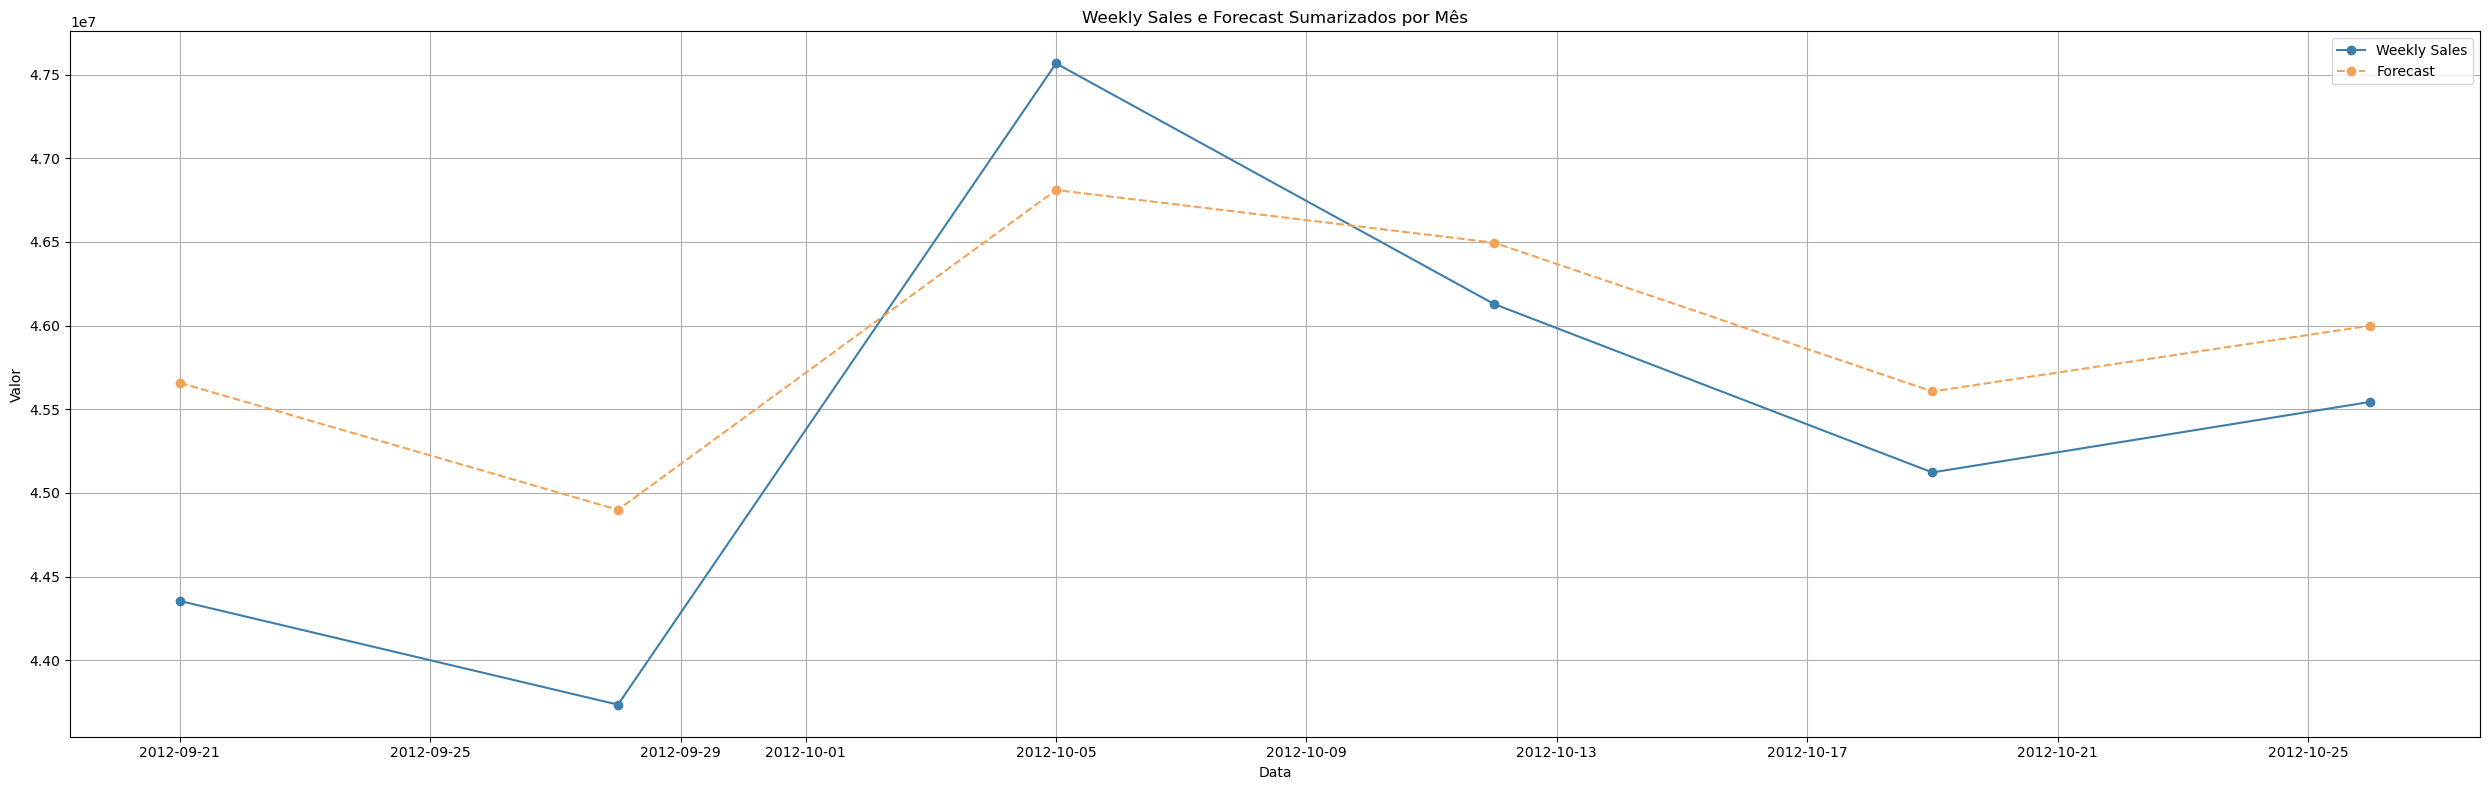

In [526]:
plt.plot(df_forecast_gp.index, df_forecast_gp['Weekly_Sales'], label='Weekly Sales', color='#3e7eac', marker='o')
plt.plot(df_forecast_gp.index, df_forecast_gp['Forecast'], label='Forecast', color='#f4a258', marker='o', linestyle='--')

plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Weekly Sales e Forecast Sumarizados por Mês')
plt.legend()
plt.xticks(rotation=0)
plt.grid(True)
plt.tight_layout()
plt.show()

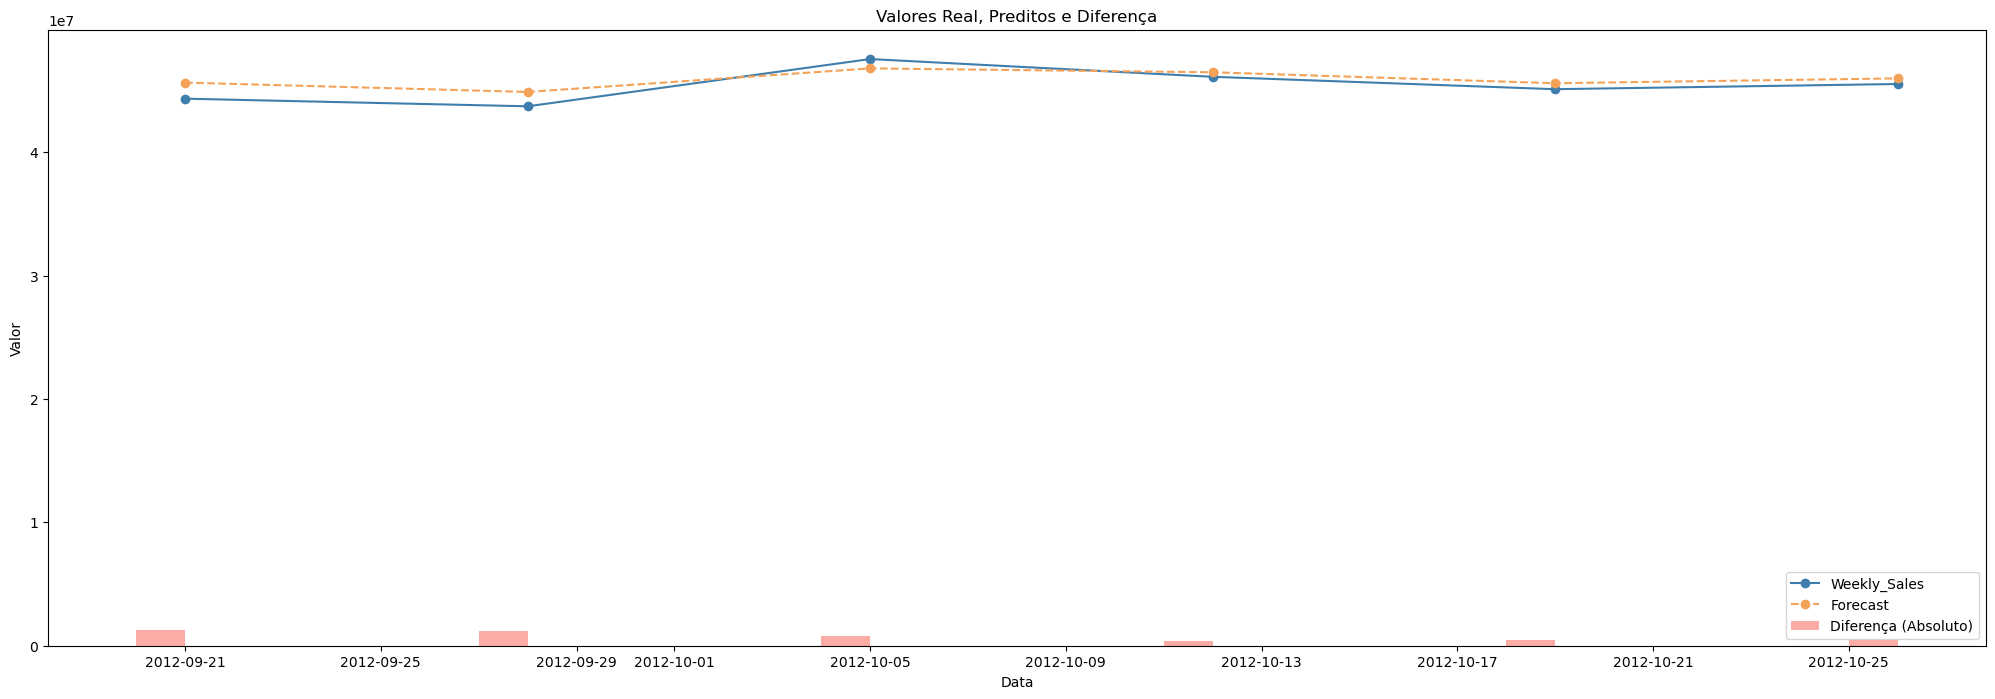

In [527]:
# Gráfico com os valores reais e preditos nas linhas + valores de erro nas barras

df_forecast_gp['Diferenca'] = df_forecast_gp['Weekly_Sales'] - df_forecast_gp['Forecast']

plt.plot(df_forecast_gp.index, df_forecast_gp['Weekly_Sales'], color='#3e7eac', label='Weekly_Sales', marker='o')
plt.plot(df_forecast_gp.index, df_forecast_gp['Forecast'], color='#f4a258', label='Forecast', marker='o', linestyle='--')

bar_width = 1
plt.bar(df_forecast_gp.index - pd.to_timedelta(bar_width/2, unit='D'), df_forecast_gp['Diferenca'].abs(), color='#fbaca4', label='Diferença (Absoluto)', width=bar_width)

plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Valores Real, Preditos e Diferença')
plt.legend()
plt.show()

### Validando os vários departamentos

In [528]:
df_forecast.head()

,Store,Dept,Weekly_Sales,Forecast
Date,,,,
2012-09-21,1.0,1.0,19251.50,19727.226562
2012-09-28,1.0,1.0,18947.81,16133.514648
2012-10-05,1.0,1.0,21904.47,21649.296875
2012-10-12,1.0,1.0,22764.01,21462.689453
2012-10-19,1.0,1.0,24185.27,19327.261719


In [529]:
forecast_groupby_date_store = df_forecast.groupby(['Date', 'Dept'])['Forecast'].sum().reset_index()
forecast_groupby_date_store.head()

,Date,Dept,Forecast
0,2012-09-21,1.0,7.241328e+05
1,2012-09-21,2.0,2.004940e+06
2,2012-09-21,3.0,6.480227e+05
3,2012-09-21,4.0,1.210497e+06
4,2012-09-21,5.0,6.810448e+05


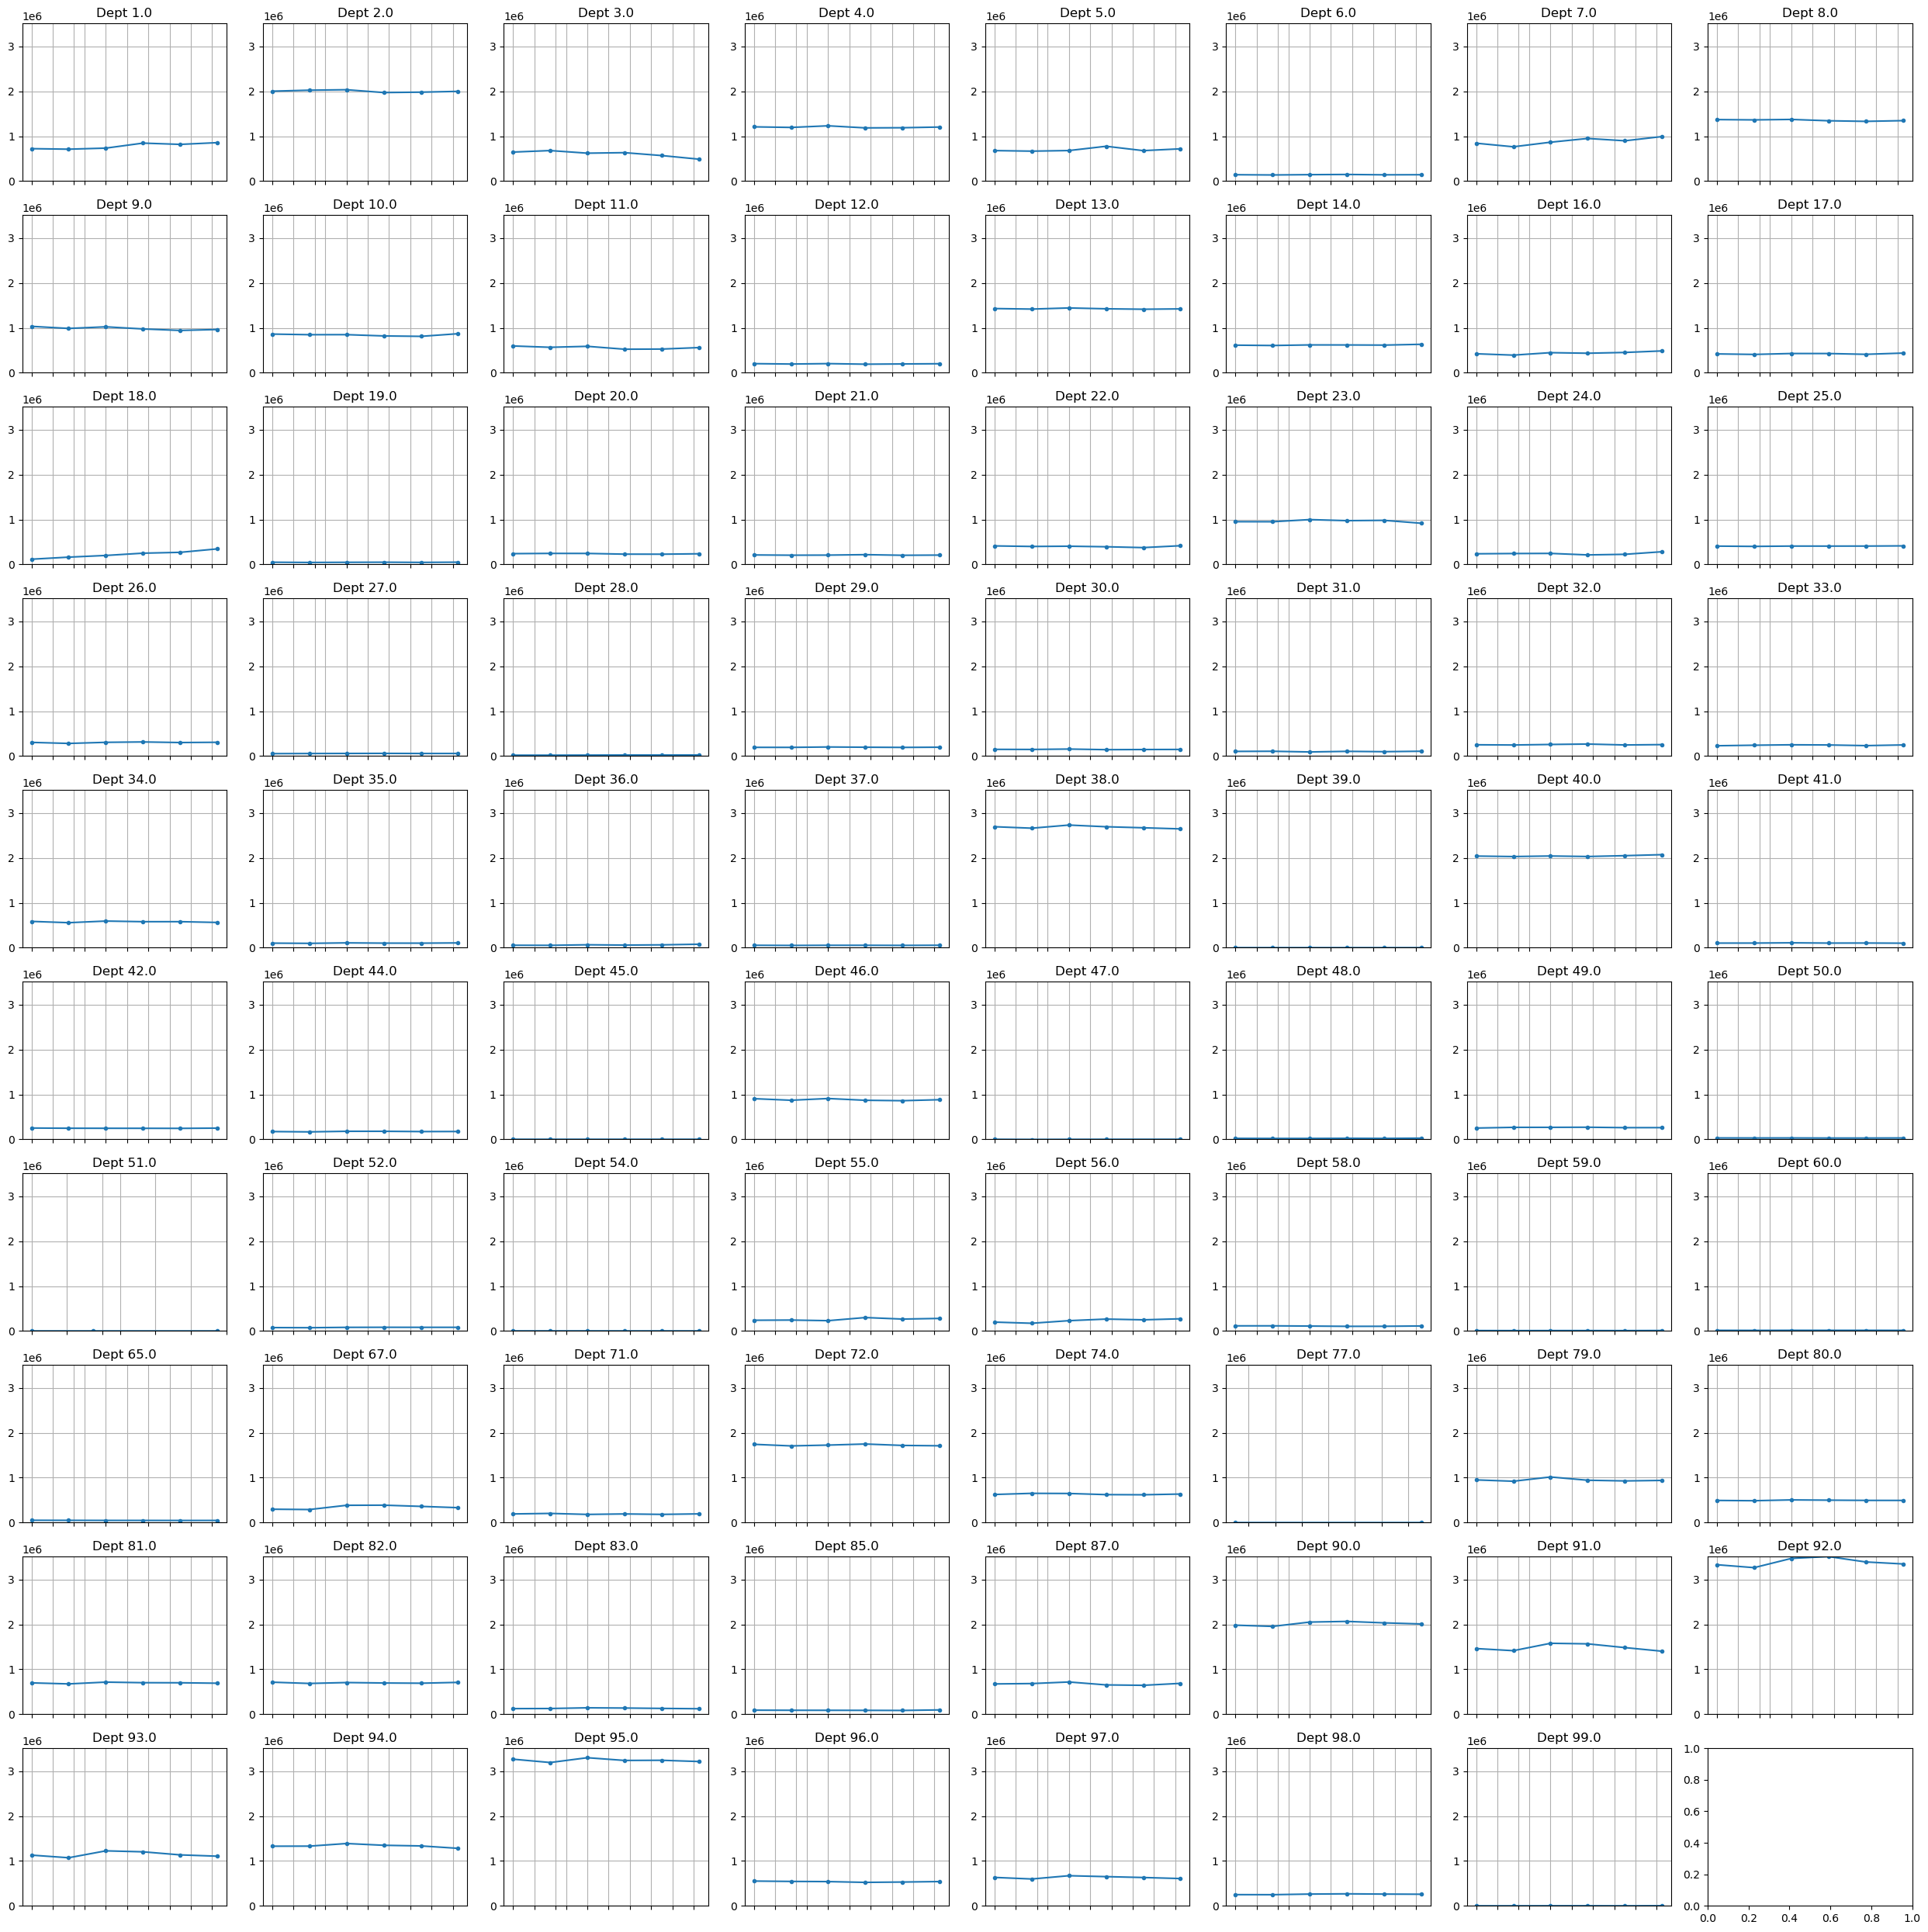

In [530]:
# Gerar uma timeline para cada departamento

fig, axs = plt.subplots(10, 8, figsize=(25, 25))
ylim_top = forecast_groupby_date_store['Forecast'].max()

for ax, (dept, data) in zip(axs.flatten(), forecast_groupby_date_store.groupby('Dept')):
    ax.plot(data['Date'], data['Forecast'], marker='.')
    ax.set_title(f'Dept {dept}')
    ax.grid(True)
    ax.set_xticklabels([])
    ax.set_ylim(bottom=0)
    ax.set_ylim(top=ylim_top)
    
plt.tight_layout()
plt.show()

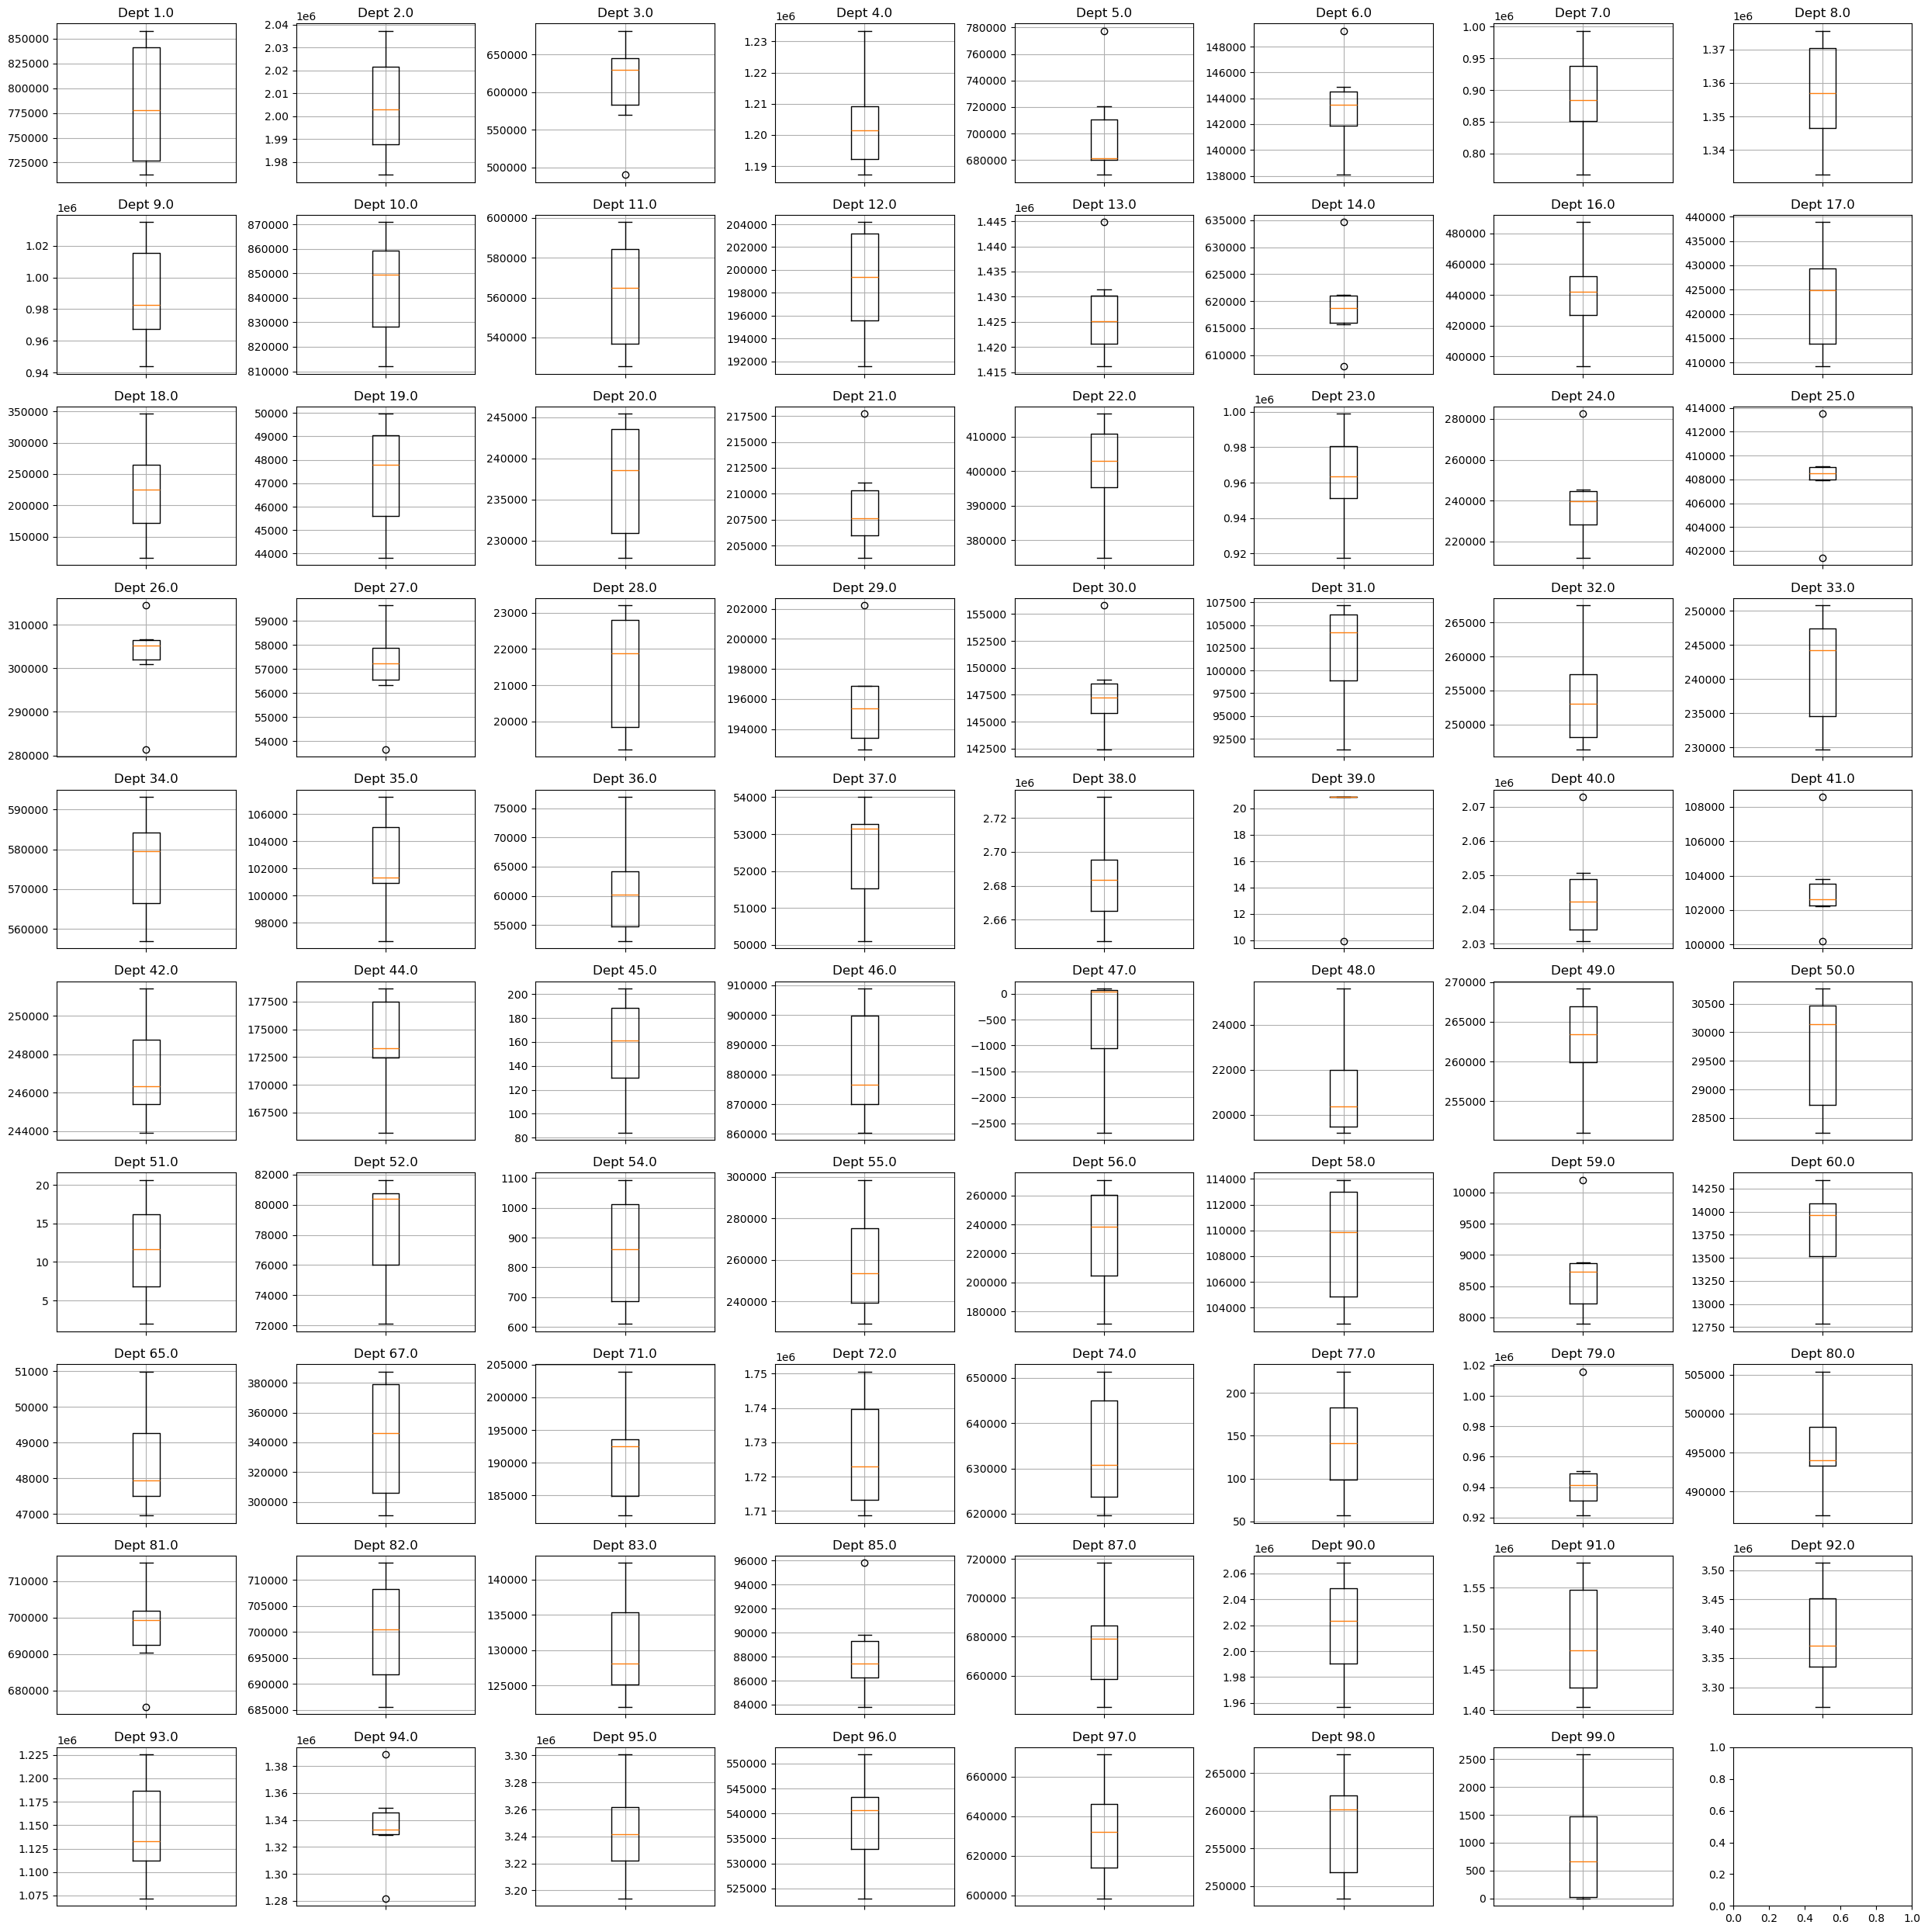

In [531]:
fig, axs = plt.subplots(10, 8, figsize=(25, 25))

# Gerar um boxplot para cada loja
for ax, (dept, data) in zip(axs.flatten(), forecast_groupby_date_store.groupby('Dept')):
    ax.boxplot(data['Forecast'], vert=True)
    ax.set_title(f'Dept {dept}')
    ax.grid(True)
    ax.set_xticklabels([])

# Ajustar o layout da figura
plt.tight_layout()
plt.show()

# Avaliar outros modelos